
------

### ---- COMPARATIVA DE RATAS SANAS VS ALCOHOLICAS PARA CONJUNTOS DE 18 RATAS CON TH=0.0 ----
#### DATOS ALEJANDRO 23.12.25

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from pathlib import Path
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy, wasserstein_distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import defaultdict
from collections import Counter

# HELPER FUNCTIONS

# --- Construcción robusta del name_map con IDs reales ---
def make_name_map_from_ids(roi_names, left_ids, right_ids):
    """
    roi_names: lista de 78 nombres base en el orden correcto del atlas.
    left_ids, right_ids: listas con los IDs REALES que corresponden a esos 78 nombres.
                         Deben tener len()==len(roi_names).
    Devuelve dict {roi_id: "L-<name>" / "R-<name>"}.
    """
    if len(left_ids) != len(roi_names) or len(right_ids) != len(roi_names):
        raise ValueError("left_ids y right_ids deben tener la misma longitud que roi_names (79).")

    name_map = {}
    for k, rid in enumerate(left_ids):
        name_map[int(rid)] = f"L-{roi_names[k]}"
    for k, rid in enumerate(right_ids):
        name_map[int(rid)] = f"R-{roi_names[k]}"
    return name_map

# --- Etiquetador que NO asume contigüidad ---
def roi_label(idx, name_map):
    """
    idx: ROI id real (disperso). name_map: dict {id: 'L-Name'/'R-Name'}.
    """
    try:
        return name_map[int(idx)]
    except KeyError:
        return f"ID{int(idx)}"  # fallback visible

In [2]:
# === CELDA 2: Carga de nombres ROI ===

os.chdir("../..") if os.getcwd().endswith('data_analysis') else None

# Path datos th=0.0 healthy
path = './data/raw/'

# Buscar archivo de nombres
names = [f for f in os.listdir(path) if 'name' in f.lower()]

if names:
    with open(path + names[0], 'r') as f:
        roi_names = [line.strip() for line in f.readlines()][1:] #TODO REVISAR PRIMER LABEL


print(f"✓ ROIs cargados: {len(roi_names)}")
print(f"Primeros 5: {roi_names[:5]}")

✓ ROIs cargados: 78
Primeros 5: ['White matter', 'Ventricles', 'Superior colliculus', 'Olfactory bulb', 'Lateral lemniscus']


In [3]:
# === CELDA 3: Carga de datos .dat ===

CONDITION = 'healthy' 

def load_all_rats(data_dir, threshold='0.0', condition='healthy'):
    """Carga archivos .dat de todas las ratas"""
    rats = {}
    path = Path(data_dir) / f'rat_delays_fibers_{threshold}' / f'th-{threshold}_{condition}'
    
    for rat_dir in sorted(path.glob('R*')):
        if not rat_dir.is_dir():
            continue
            
        rat_id = rat_dir.name
        dat_file = rat_dir / f'th-{threshold}_{rat_id}_b20_r_Fit_Histogram_Tau_all_fibers.dat'
        
        if dat_file.exists():
            with open(dat_file, 'rb') as fh:
                rats[rat_id] = pickle.load(fh)
    
    return rats

# Cargar ambos grupos
healthy_rats = load_all_rats('./data/raw/', threshold='0.0', condition='healthy')
alcoholic_rats = load_all_rats('./data/raw/', threshold='0.0', condition='alcoholic')

print(f"✓ Healthy: {len(healthy_rats)} ratas - {sorted(healthy_rats.keys())}")
print(f"✓ Alcoholic: {len(alcoholic_rats)} ratas - {sorted(alcoholic_rats.keys())}")

# Info estructura
if healthy_rats:
    first_h = list(healthy_rats.keys())[0]
    sample_pair = list(healthy_rats[first_h].keys())[0]
    sample_data = np.array(healthy_rats[first_h][sample_pair])
    print(f"\n✓ Conexiones por rata: ~{len(healthy_rats[first_h])}")
    print(f"✓ Ejemplo par {sample_pair}: {sample_data.shape[0]} fibras, {sample_data.shape[1]} columnas")
    print(f"✓ Columnas: [delays, distancias, velocidades, ...]")

✓ Healthy: 18 ratas - ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19']
✓ Alcoholic: 18 ratas - ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19']

✓ Conexiones por rata: ~3937
✓ Ejemplo par (3, 4): 13 fibras, 6 columnas
✓ Columnas: [delays, distancias, velocidades, ...]


In [4]:
# === CELDA 4: Mapeo IDs y exploración comparativa ===
left_ids = range(0, 78)
right_ids = range(78, 156)
name_map = make_name_map_from_ids(roi_names, left_ids, right_ids)

# Contar presencia de pares en cada grupo
pairs_healthy = Counter()
pairs_alcoholic = Counter()

for rat_data in healthy_rats.values():
    pairs_healthy.update(rat_data.keys())
    
for rat_data in alcoholic_rats.values():
    pairs_alcoholic.update(rat_data.keys())

# Análisis comparativo
pairs_h_set = set(pairs_healthy.keys())
pairs_a_set = set(pairs_alcoholic.keys())
common_pairs = pairs_h_set & pairs_a_set

print(f"{'='*60}")
print(f"HEALTHY:")
print(f"  Total conexiones únicas: {len(pairs_healthy)}")
print(f"  Conexiones en ≥9 ratas: {sum(1 for c in pairs_healthy.values() if c >= 9)}")
print(f"  Conexiones en 18 ratas: {sum(1 for c in pairs_healthy.values() if c == 18)}")

print(f"\nALCOHOLIC:")
print(f"  Total conexiones únicas: {len(pairs_alcoholic)}")
print(f"  Conexiones en ≥9 ratas: {sum(1 for c in pairs_alcoholic.values() if c >= 9)}")
print(f"  Conexiones en 18 ratas: {sum(1 for c in pairs_alcoholic.values() if c == 18)}")

print(f"\nCOMPARATIVA:")
print(f"  Pares comunes: {len(common_pairs)}")
print(f"  Solo healthy: {len(pairs_h_set - pairs_a_set)}")
print(f"  Solo alcoholic: {len(pairs_a_set - pairs_h_set)}")

print(f"\n{'='*60}")
print(f"Top 10 conexiones más frecuentes (HEALTHY):")
for (i,j), count in pairs_healthy.most_common(10):
    print(f"  {roi_label(i, name_map)} → {roi_label(j, name_map)}: {count}/18 ratas")

print(f"\nTop 10 conexiones más frecuentes (ALCOHOLIC):")
for (i,j), count in pairs_alcoholic.most_common(10):
    print(f"  {roi_label(i, name_map)} → {roi_label(j, name_map)}: {count}/18 ratas")

HEALTHY:
  Total conexiones únicas: 7263
  Conexiones en ≥9 ratas: 3409
  Conexiones en 18 ratas: 1470

ALCOHOLIC:
  Total conexiones únicas: 7021
  Conexiones en ≥9 ratas: 3361
  Conexiones en 18 ratas: 1328

COMPARATIVA:
  Pares comunes: 6273
  Solo healthy: 990
  Solo alcoholic: 748

Top 10 conexiones más frecuentes (HEALTHY):
  L-Olfactory bulb → L-Secondary auditory area: 18/18 ratas
  L-Olfactory bulb → L-Nucleus accumbens: 18/18 ratas
  L-Olfactory bulb → L-Subiculum: 18/18 ratas
  L-Olfactory bulb → L-Subthalamic nucleus: 18/18 ratas
  L-Olfactory bulb → L-Entopeduncular nucleus: 18/18 ratas
  L-Olfactory bulb → L-Hypothalamic region, unspecified: 18/18 ratas
  L-Olfactory bulb → L-Pontine nuclei: 18/18 ratas
  L-Olfactory bulb → L-Postrhinal cortex: 18/18 ratas
  L-Olfactory bulb → L-Secondary somatosensory area: 18/18 ratas
  L-Olfactory bulb → L-Primary motor area: 18/18 ratas

Top 10 conexiones más frecuentes (ALCOHOLIC):
  L-Olfactory bulb → L-Secondary auditory area: 18/1

- Pérdida de robustez: Alcoholic tiene 142 pares menos con presencia en las 18 ratas (1470→1328). Esto sugiere mayor heterogeneidad inter-sujeto o pérdida de conectividad estructural.
- Pares comunes: 6273 pares presentes en ambos grupos → núcleo principal para comparación.
- Pares exclusivos: 990 healthy-only vs 748 alcoholic-only. Podrían ser:

- Ruido (conexiones débiles detectadas aleatoriamente)
- Señal biológica real (conexiones ganadas/perdidas por patología)


- Olfactory bulb dominance: Es hub masivo. Verificar si esto es artefacto metodológico o biología real del tracto olfatorio en roedores.

In [5]:
# === CELDA 6: Construcción DataFrames nivel rata ===
COL_TAU = 0
COL_D = 1
COL_V = 2

def build_rat_level_df(rats_dict, condition):
    """Extrae delays y construye DataFrame por rata individual"""
    rows = []
    for rat_id, rat_data in rats_dict.items():
        for (i, j), fibers in rat_data.items():
            # print(np.array(fibers).shape)
            if np.array(fibers).shape[0] == 0:
                continue
            delays = np.array(fibers)[:, COL_TAU]
            rows.append({
                'rat_id': rat_id,
                'condition': condition,
                'roi_i': i,
                'roi_j': j,
                'mean_delay': np.mean(delays),
                'std_delay': np.std(delays),
                'min_delay': delays.min(),
                'max_delay': delays.max(),
                'median_delay': np.median(delays),
                'q25_delay': np.percentile(delays, 25),
                'q75_delay': np.percentile(delays, 75),
                'n_fibers': len(delays)
            })
    return pd.DataFrame(rows)

# Construir DataFrames
df_healthy = build_rat_level_df(healthy_rats, 'healthy')
df_alcoholic = build_rat_level_df(alcoholic_rats, 'alcoholic')
df_all_rats = pd.concat([df_healthy, df_alcoholic], ignore_index=True)

print(f"✓ DataFrame nivel rata:")
print(f"  Healthy: {len(df_healthy)} conexiones-rata")
print(f"  Alcoholic: {len(df_alcoholic)} conexiones-rata")
print(f"  Total: {len(df_all_rats)} filas")
df_all_rats.head(10)

✓ DataFrame nivel rata:
  Healthy: 63634 conexiones-rata
  Alcoholic: 61059 conexiones-rata
  Total: 124693 filas


rat_id condition  roi_i  roi_j  mean_delay  std_delay  min_delay  max_delay  \
0    R01   healthy      3      4    0.002182   0.000765   0.001692   0.004737   
1    R01   healthy      3      6    0.000088   0.000133   0.000009   0.001081   
2    R01   healthy      3      9    0.001974   0.000158   0.001701   0.002073   
3    R01   healthy      3     10    0.002042   0.001753   0.000796   0.005122   
4    R01   healthy      3     15    0.000290   0.000139   0.000151   0.000429   
5    R01   healthy      3     16    0.000433   0.000240   0.000136   0.001538   
6    R01   healthy      3     17    0.000435   0.000166   0.000171   0.000661   
7    R01   healthy      3     18    0.000321   0.000037   0.000249   0.000346   
8    R01   healthy      3     19    0.000561   0.000650   0.000129   0.004660   
9    R01   healthy      3     21    0.001341   0.001520   0.000280   0.004565   

   median_delay  q25_delay  q75_delay  n_fibers  
0      0.002003   0.001841   0.002007        13  
1      0.000051   0.000043   0.000056       224  
2      0.002060   0.001962   0.002072         4  
3      0.000973   0.000863   0.004695        28  
4      0.000290   0.000220   0.000359         2  
5      0.000370   0.000285   0.000461       160  
6      0.000423   0.000310   0.000584        29  
7      0.000340   0.000324   0.000345         5  
8      0.000515   0.000194   0.000765        97  
9      0.000638   0.000537   0.000949       173

In [6]:
df_healthy.describe()

roi_i         roi_j    mean_delay     std_delay     min_delay  \
count  63634.000000  63634.000000  63634.000000  63634.000000  63634.000000   
mean      60.612063     97.360515      0.001058      0.000282      0.000659   
std       40.607357     40.594036      0.000665      0.000270      0.000612   
min        3.000000      4.000000      0.000000      0.000000      0.000000   
25%       25.000000     62.000000      0.000561      0.000099      0.000173   
50%       51.000000    107.000000      0.000958      0.000221      0.000514   
75%       97.000000    134.000000      0.001423      0.000387      0.000983   
max      155.000000    156.000000      0.007567      0.004717      0.007147   

          max_delay  median_delay     q25_delay     q75_delay      n_fibers  
count  63634.000000  63634.000000  63634.000000  63634.000000  63634.000000  
mean       0.001940      0.001013      0.000869      0.001199    233.892887  
std        0.001236      0.000682      0.000640      0.000756    549.643624  
min        0.000000      0.000000      0.000000      0.000000      1.000000  
25%        0.001124      0.000498      0.000371      0.000651      8.000000  
50%        0.001708      0.000909      0.000760      0.001087     48.000000  
75%        0.002463      0.001389      0.001226      0.001592    211.000000  
max        0.014243      0.008058      0.007574      0.011619   9883.000000

In [7]:
# === CELDA 7: Agregación por par (roi_i, roi_j) ===
def aggregate_by_pair(df, min_rats=9, min_fibers=50):
    """
    Agrega métricas por par (roi_i, roi_j) entre ratas de la misma condición.
    Filtra por presencia mínima de ratas y fibras.
    """
    grouped = df.groupby(['condition', 'roi_i', 'roi_j']).agg({
        'mean_delay': ['mean', 'std', 'median'],
        'std_delay': 'mean',
        'n_fibers': ['mean', 'sum'],
        'rat_id': 'count'
    }).reset_index()
    
    # Aplanar columnas multi-nivel
    grouped.columns = ['condition', 'roi_i', 'roi_j', 
                       'mean_delay', 'std_between_rats', 'median_delay',
                       'mean_std_within_rat', 'mean_n_fibers', 'total_fibers', 'n_rats']
    
    # Calcular CV inter-rata
    grouped['cv_inter_rat'] = grouped['std_between_rats'] / grouped['mean_delay']
    
    # Filtrar
    filtered = grouped[
        (grouped['n_rats'] >= min_rats) & 
        (grouped['mean_n_fibers'] >= min_fibers)
    ].copy()
    
    return filtered

df_agg = aggregate_by_pair(df_all_rats, min_rats=9, min_fibers=50)

print(f"✓ Pares agregados (≥9 ratas, ≥50 fibras/rata):")
print(f"  Total: {len(df_agg)}")
print(f"  Healthy: {len(df_agg[df_agg.condition=='healthy'])}")
print(f"  Alcoholic: {len(df_agg[df_agg.condition=='alcoholic'])}")
df_agg.head(10)

✓ Pares agregados (≥9 ratas, ≥50 fibras/rata):
  Total: 4362
  Healthy: 2161
  Alcoholic: 2201


condition  roi_i  roi_j  mean_delay  std_between_rats  median_delay  \
2   alcoholic      3      6    0.000157          0.000076      0.000153   
8   alcoholic      3     16    0.000360          0.000201      0.000331   
18  alcoholic      3     26    0.000478          0.000194      0.000447   
21  alcoholic      3     29    0.000370          0.000175      0.000333   
22  alcoholic      3     30    0.000256          0.000144      0.000238   
24  alcoholic      3     32    0.001210          0.000326      0.001156   
26  alcoholic      3     35    0.000248          0.000122      0.000226   
28  alcoholic      3     37    0.000168          0.000085      0.000154   
31  alcoholic      3     44    0.000232          0.000150      0.000186   
33  alcoholic      3     48    0.001133          0.000334      0.001082   

    mean_std_within_rat  mean_n_fibers  total_fibers  n_rats  cv_inter_rat  
2              0.000138     150.555556          2710      18      0.481538  
8              0.000219      54.312500           869      16      0.559142  
18             0.000291     353.722222          6367      18      0.405180  
21             0.000321     377.555556          6796      18      0.473046  
22             0.000214     629.611111         11333      18      0.561637  
24             0.000508     332.833333          5991      18      0.269196  
26             0.000214     240.833333          4335      18      0.491798  
28             0.000160      68.333333          1230      18      0.504202  
31             0.000197     117.833333          2121      18      0.646052  
33             0.000340     124.882353          2123      17      0.295104

Técnicas aplicables:
1. Feature Engineering (extraer de distribuciones completas):

Momentos estadísticos: skewness, kurtosis de delays por par
Percentiles: P10, P50, P90 (cambios en colas)
Métricas de forma: coeficiente de variación, IQR/median
Entropía de histogramas (medir "desorden")
Wasserstein distance entre distribuciones healthy-alcoholic por par

2. Statistical Tests (con corrección múltiple):

Mann-Whitney U por cada par (i,j) común
Kolmogorov-Smirnov 2-sample (detecta cambios en forma)
Permutation tests para robustez
FDR correction (Benjamini-Hochberg)

3. Supervised Learning (clasificación):

Random Forest/XGBoost: clasificar condition usando features de delay

Input: mean_delay, std, cv, n_fibers, etc.
Output: healthy/alcoholic
Feature importance → qué métricas discriminan más


Logistic Regression para interpretabilidad

4. Unsupervised (validación):

PCA sobre features → ver separación natural
K-means clustering → verificar si emerge separación healthy/alcoholic sin labels
t-SNE/UMAP para visualización 2D

5. Network Analysis:

Tratar 156 ROIs como nodos, delays como pesos
Comparar graph metrics: betweenness centrality, modularity, small-worldness
Identificar hubs afectados

In [8]:
# Filtrar antes
df_healthy_filt = df_healthy.groupby(['roi_i', 'roi_j']).filter(
    lambda x: len(x) >= 9 and x['n_fibers'].mean() >= 50
)
df_alcoholic_filt = df_alcoholic.groupby(['roi_i', 'roi_j']).filter(
    lambda x: len(x) >= 9 and x['n_fibers'].mean() >= 50
)

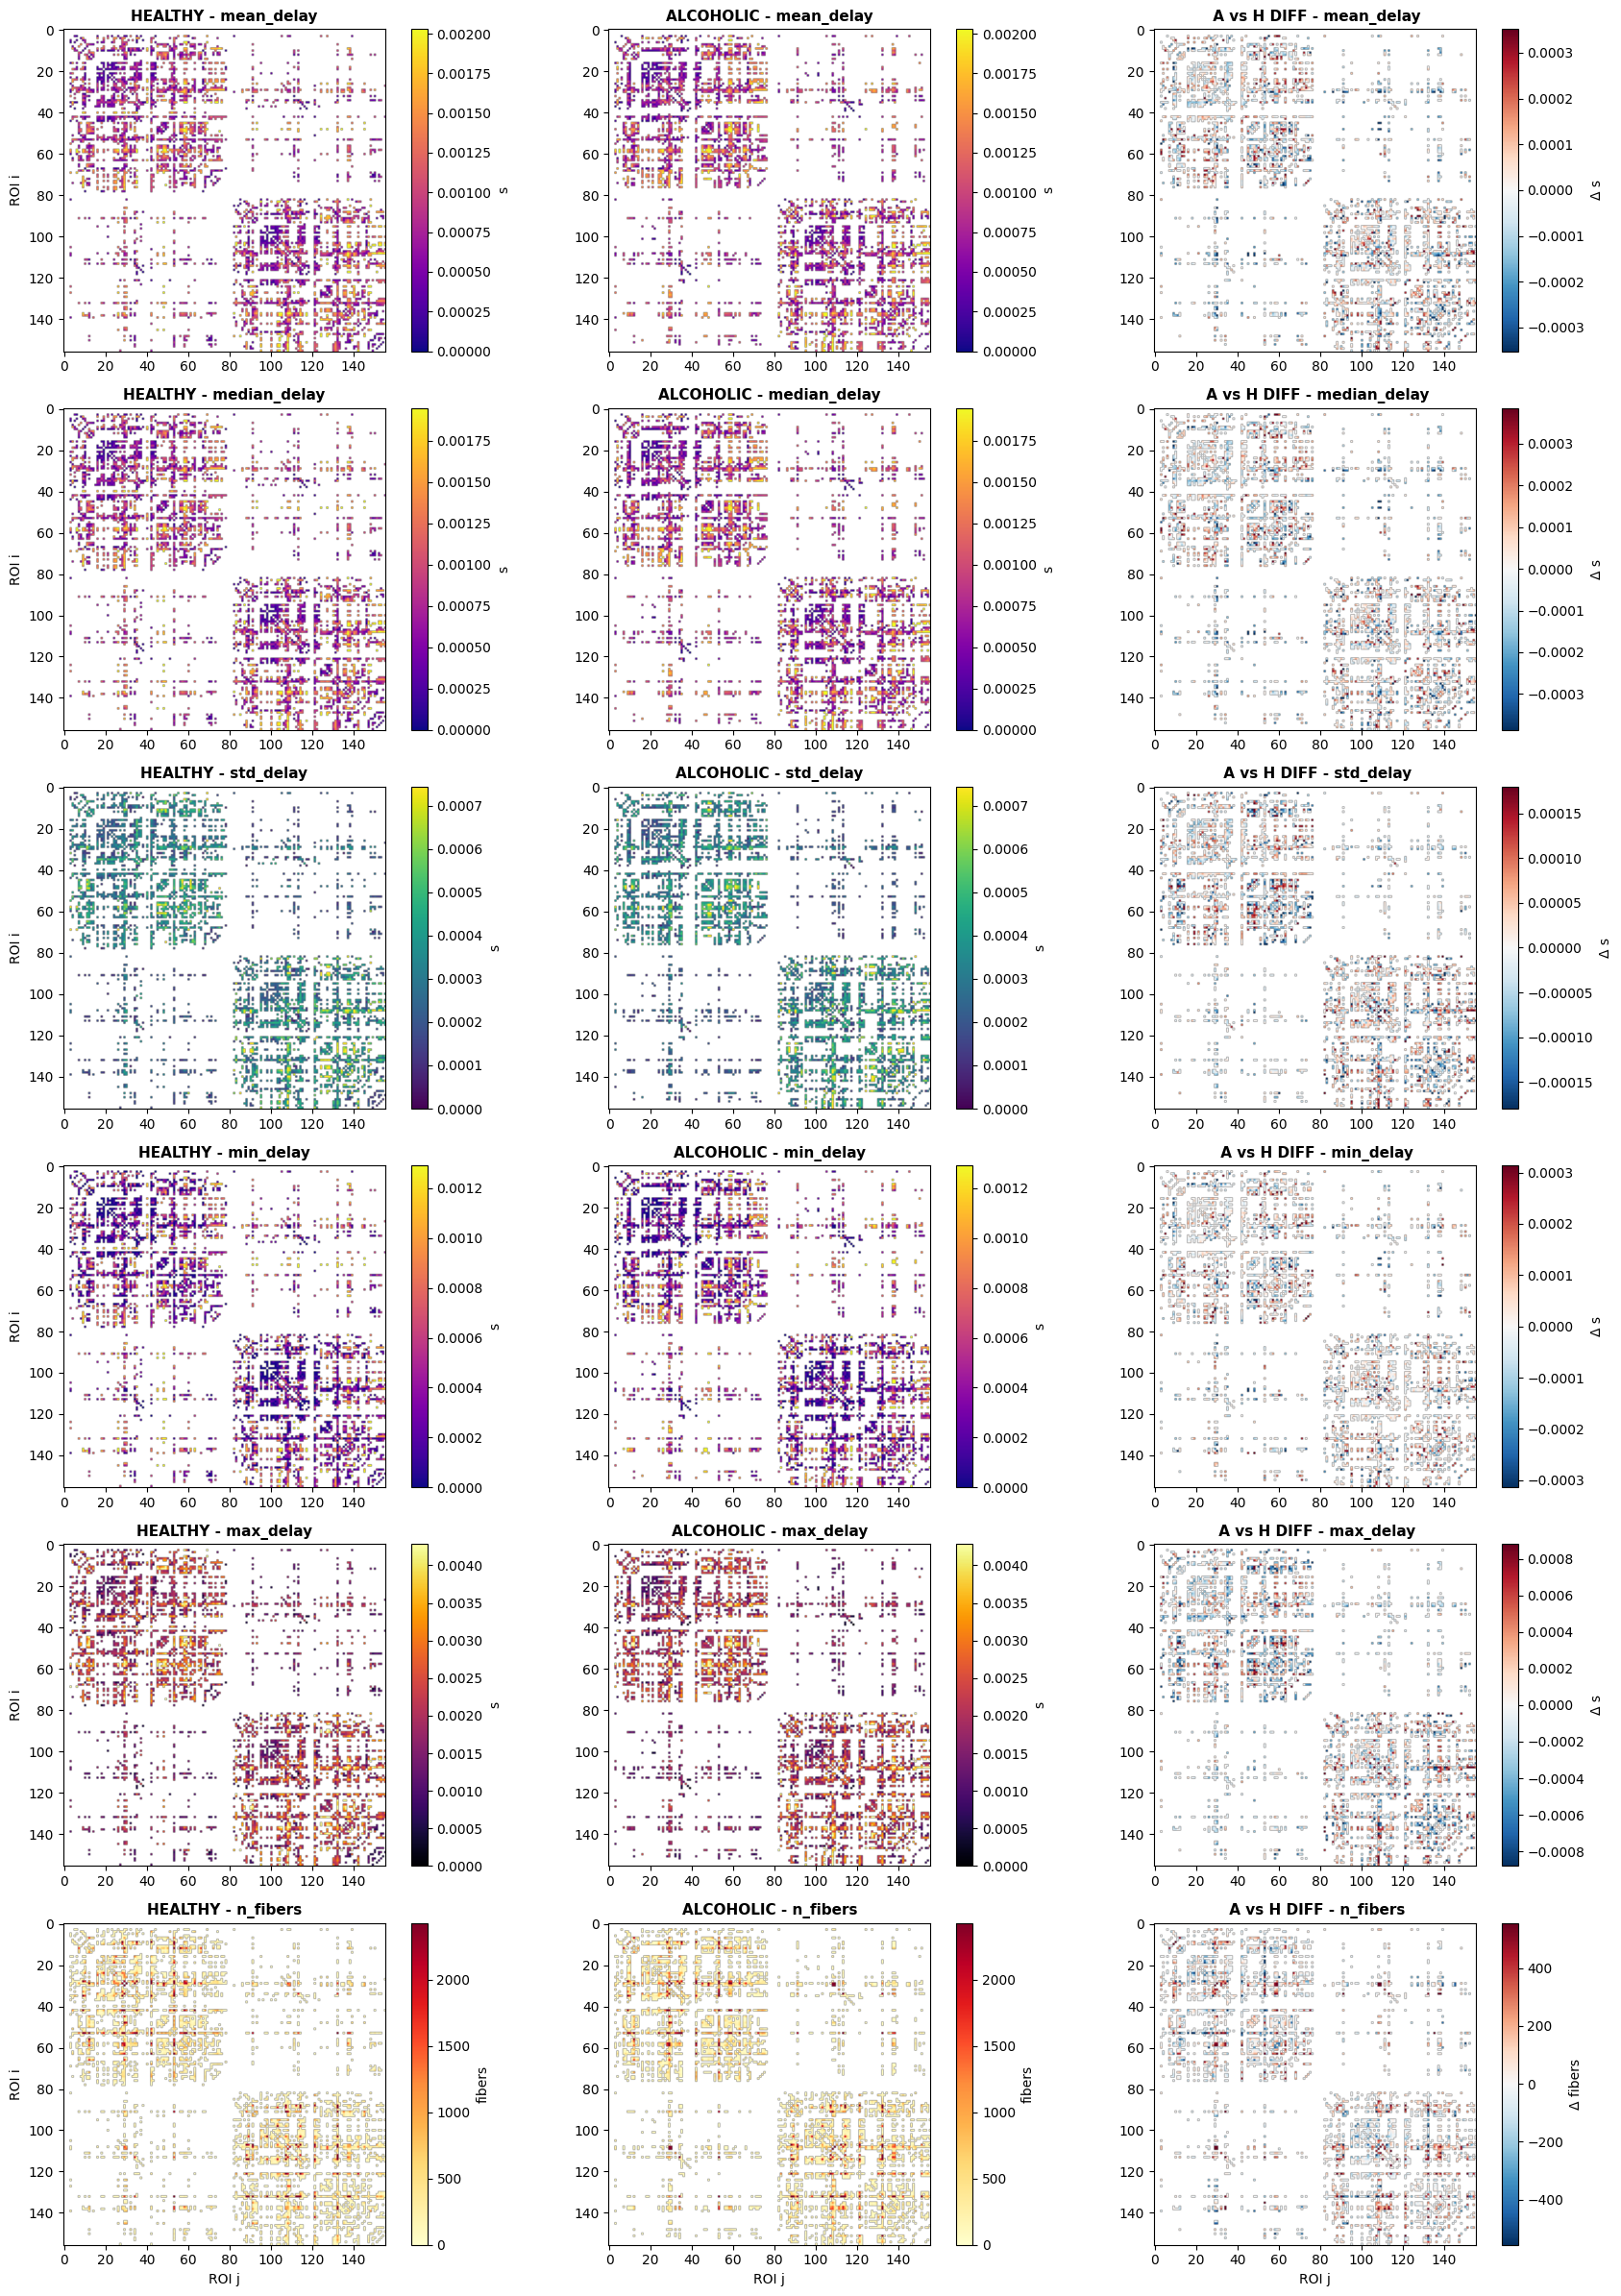

METRIC          |          HEALTHY          |         ALCOHOLIC         |        DIFFERENCE        

MEAN_DELAY (s):
  N pairs      |           4316            |           4402            |           3652           
  Mean ± Std   |   0.000917 ± 0.000471 |   0.000923 ± 0.000478 |  -0.000003 ± 0.000153
  Range        | [0.000073, 0.002550] | [0.000031, 0.002636] | [-0.000715, 0.000855]
  Change       |             -             |             -             | ↑ 50.2%  ↓ 49.8%

MEDIAN_DELAY (s):
  N pairs      |           4316            |           4402            |           3652           
  Mean ± Std   |   0.000859 ± 0.000471 |   0.000865 ± 0.000477 |  -0.000003 ± 0.000160
  Range        | [0.000057, 0.002473] | [0.000026, 0.002653] | [-0.000767, 0.000880]
  Change       |             -             |             -             | ↑ 50.4%  ↓ 49.6%

STD_DELAY (s):
  N pairs      |           4316            |           4402            |           3652           
  Mean ± Std   |   0.000334

In [9]:
# === CELDA 8: Matrices de delays promedio por condición ===
def build_delay_matrix(df, metric='mean_delay'):
    """Construye matriz 156x156 de delays, promediando entre ratas"""
    # Agrupar por par y promediar
    grouped = df.groupby(['roi_i', 'roi_j'])[metric].mean()
    
    # Matriz simétrica
    matrix = np.full((156, 156), np.nan)
    for (i, j), val in grouped.items():
        try:
            matrix[i, j] = val
            matrix[j, i] = val  # simetrizar
        except:
            pass
    
    return matrix


# === CELDA 8-9 MEJORADA: Multi-métrica con unidades y mejor contraste ===
metrics_info = {
    'mean_delay': {'unit': 's', 'cmap': 'plasma'},
    'median_delay': {'unit': 's', 'cmap': 'plasma'},
    'std_delay': {'unit': 's', 'cmap': 'viridis'},
    'min_delay': {'unit': 's', 'cmap': 'plasma'},
    'max_delay': {'unit': 's', 'cmap': 'inferno'},
    # 'median_delay': {'unit': 's', 'cmap': 'plasma'},
    # 'q25_delay': {'unit': 's', 'cmap': 'plasma'},
    # 'q75_delay': {'unit': 's', 'cmap': 'plasma'},
    'n_fibers': {'unit': 'fibers', 'cmap': 'YlOrRd'}
}

# CONSTRUIR TODAS LAS MATRICES
matrices = {}
for metric in metrics_info.keys():
    mat_h = build_delay_matrix(df_healthy_filt, metric=metric) # df_healthy_filt
    mat_a = build_delay_matrix(df_alcoholic_filt, metric=metric) # df_alcoholic_filt
    matrices[metric] = {
        'healthy': mat_h,
        'alcoholic': mat_a,
        'diff': mat_a - mat_h
    }

fig, axes = plt.subplots(len(metrics_info), 3, figsize=(18, 4*len(metrics_info)))

for idx, (metric, info) in enumerate(metrics_info.items()):
    mat_h = matrices[metric]['healthy']
    mat_a = matrices[metric]['alcoholic']
    mat_d = matrices[metric]['diff']
    
    # Usar percentiles para mejor contraste (ignora outliers extremos)
    vmax = np.nanpercentile([mat_h, mat_a], 98)
    vmin_diff = np.nanpercentile(mat_d, 2)
    vmax_diff = np.nanpercentile(mat_d, 98)
    
    # Healthy
    im1 = axes[idx, 0].imshow(mat_h, cmap=info['cmap'], vmin=0, vmax=vmax)
    axes[idx, 0].set_title(f'HEALTHY - {metric}', fontweight='bold', fontsize=11)
    axes[idx, 0].set_ylabel('ROI i')
    plt.colorbar(im1, ax=axes[idx, 0], fraction=0.046, label=info['unit'])
    
    # Alcoholic
    im2 = axes[idx, 1].imshow(mat_a, cmap=info['cmap'], vmin=0, vmax=vmax)
    axes[idx, 1].set_title(f'ALCOHOLIC - {metric}', fontweight='bold', fontsize=11)
    plt.colorbar(im2, ax=axes[idx, 1], fraction=0.046, label=info['unit'])
    
    # Diff (escala simétrica)
    abs_max = max(abs(vmin_diff), abs(vmax_diff))
    im3 = axes[idx, 2].imshow(mat_d, cmap='RdBu_r', vmin=-abs_max, vmax=abs_max)
    axes[idx, 2].set_title(f' A vs H DIFF - {metric}', fontweight='bold', fontsize=11)
    plt.colorbar(im3, ax=axes[idx, 2], fraction=0.046, label=f'Δ {info["unit"]}')
    
    if idx == len(metrics_info)-1:
        for ax in axes[idx]:
            ax.set_xlabel('ROI j')

plt.tight_layout()
plt.show()

# Stats numéricas COMPLETAS
print("="*100)
print(f"{'METRIC':<15} | {'HEALTHY':^25} | {'ALCOHOLIC':^25} | {'DIFFERENCE':^25}")
print("="*100)

for metric, info in metrics_info.items():
    mat_h = matrices[metric]['healthy']
    mat_a = matrices[metric]['alcoholic']
    mat_d = matrices[metric]['diff']
    
    n_h = (~np.isnan(mat_h)).sum()
    n_a = (~np.isnan(mat_a)).sum()
    n_d = (~np.isnan(mat_d)).sum()
    
    # Stats healthy
    h_mean = np.nanmean(mat_h)
    h_std = np.nanstd(mat_h)
    h_min = np.nanmin(mat_h)
    h_max = np.nanmax(mat_h)
    
    # Stats alcoholic
    a_mean = np.nanmean(mat_a)
    a_std = np.nanstd(mat_a)
    a_min = np.nanmin(mat_a)
    a_max = np.nanmax(mat_a)
    
    # Stats diff
    d_mean = np.nanmean(mat_d)
    d_std = np.nanstd(mat_d)
    d_min = np.nanmin(mat_d)
    d_max = np.nanmax(mat_d)
    d_pct_inc = 100*(mat_d>0).sum()/n_d
    d_pct_dec = 100*(mat_d<0).sum()/n_d
    
    print(f"\n{metric.upper()} ({info['unit']}):")
    print(f"  N pairs      | {n_h:^25} | {n_a:^25} | {n_d:^25}")
    print(f"  Mean ± Std   | {h_mean:>10.6f} ± {h_std:<8.6f} | {a_mean:>10.6f} ± {a_std:<8.6f} | {d_mean:>10.6f} ± {d_std:<8.6f}")
    print(f"  Range        | [{h_min:.6f}, {h_max:.6f}] | [{a_min:.6f}, {a_max:.6f}] | [{d_min:.6f}, {d_max:.6f}]")
    print(f"  Change       | {'-':^25} | {'-':^25} | ↑{d_pct_inc:>5.1f}%  ↓{d_pct_dec:>5.1f}%")

print("="*100)

1. Efecto global mínimo: Mean = -0.027 ms → no hay sesgo sistemático hacia delays más largos/cortos por alcoholismo.
2. Alta variabilidad local: Std = 0.39 ms con extremos de ±4-5 ms. Para delays típicos de 1-5 ms, esto representa cambios relativos del 10-100% en conexiones específicas.
3. Distribución balanceada: 48% aumentos vs 52% disminuciones → el efecto no es unidireccional (no es simplemente "pérdida de mielina global").
4. Estructura visible: Bloques en matrices sugieren:

Cuadrante superior-izquierdo (0-78): conexiones intra-hemisferio L
Cuadrante inferior-derecho (78-156): intra-hemisferio R
Off-diagonal: conexiones inter-hemisféricas

Implicaciones:

El alcoholismo no produce enlentecimiento global
Hay reorganización heterogénea: algunas conexiones aceleran, otras ralentizan
Pares con cambios ±4-5 ms son candidatos fuertes para análisis profundo

MEAN_DELAY: ~1.2 ms (0.0012 s) típico
Diferencia media: -0.027 ms (-0.000027 s) → casi nula
Rango diferencias: ±4-5 ms (±0.004-0.005 s) → cambios grandes en pares específicos

STD_DELAY aumenta en alcoholic (0.216 vs 0.209 ms): mayor dispersión temporal
N_FIBERS aumenta +8.4 fibras/par en promedio (+6.6%), pero alta variabilidad (std ~137)
Distribución balanceada: ~50/50 aumentos vs disminuciones en todas las métricas

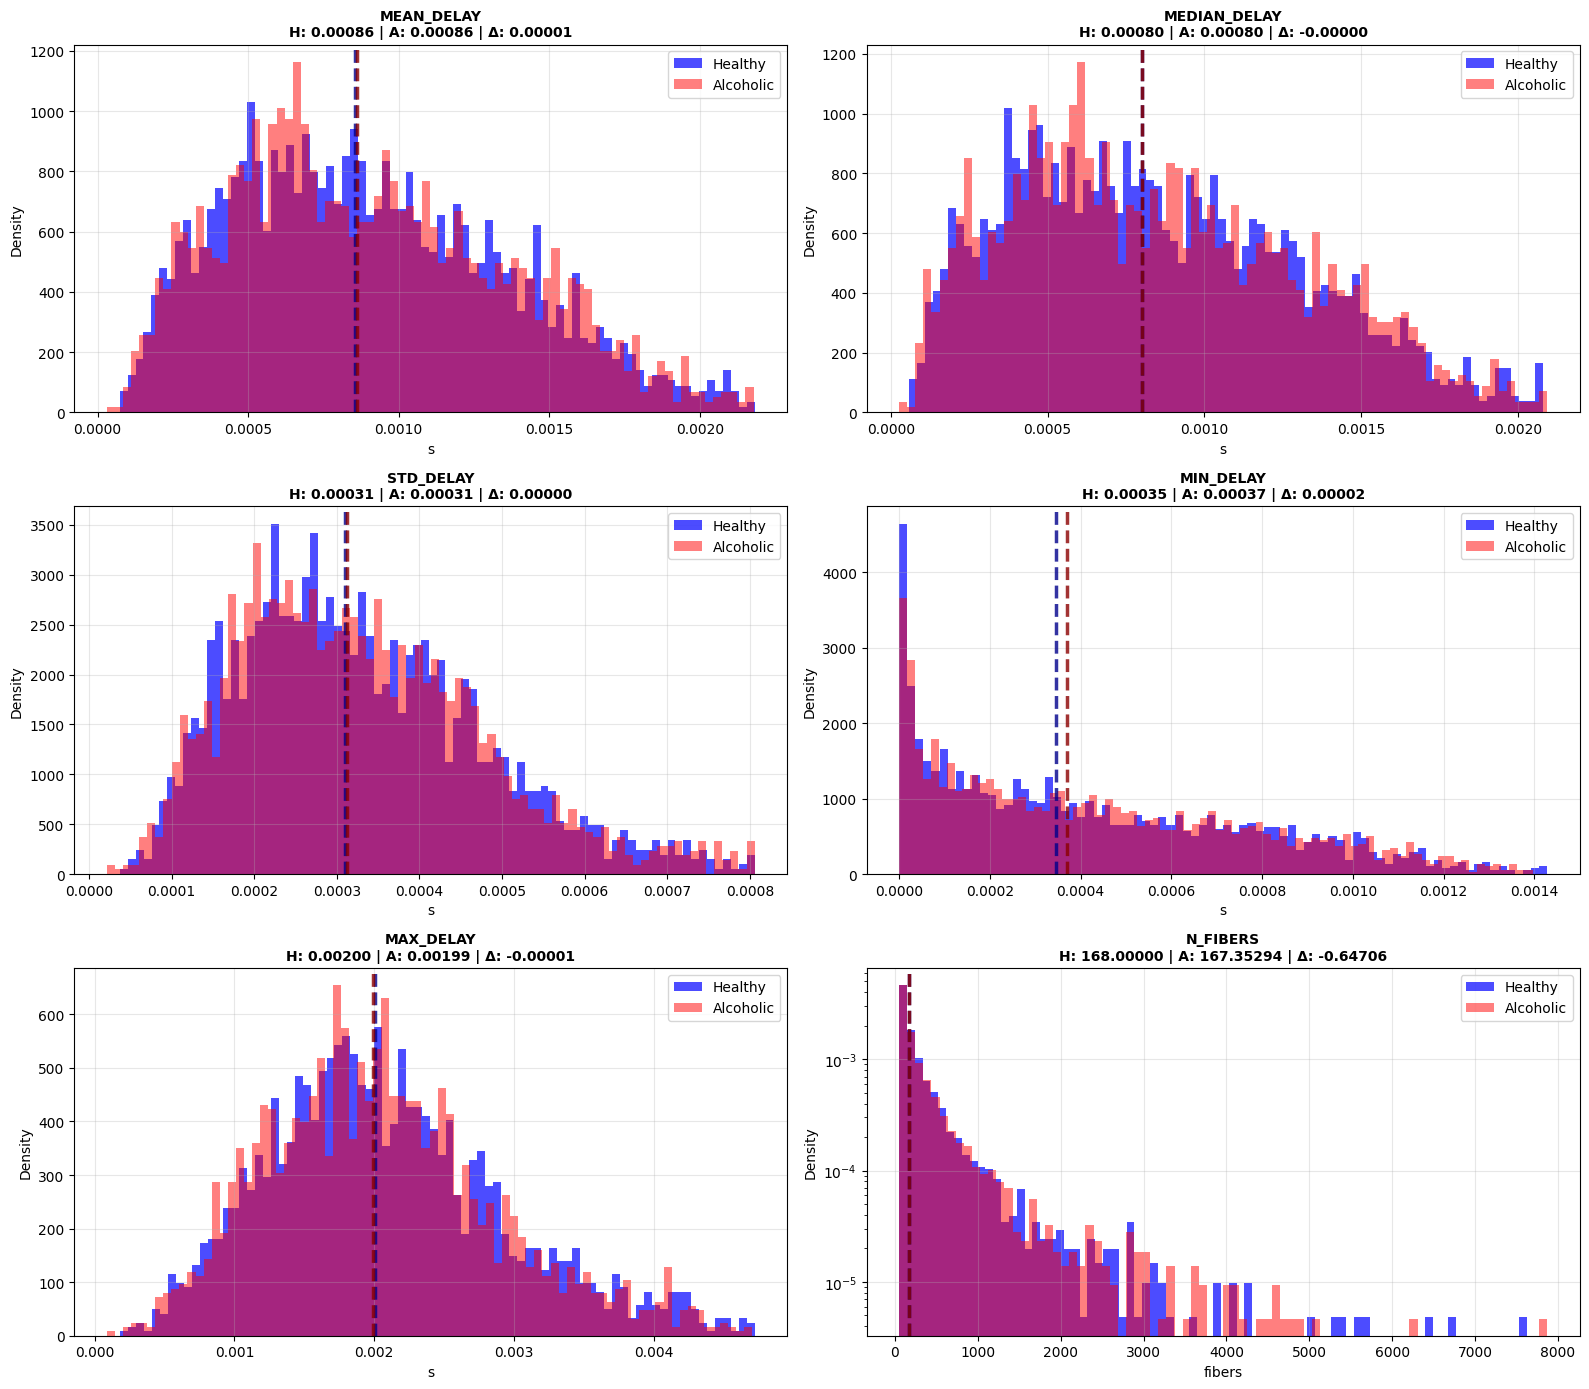


Kolmogorov-Smirnov Tests:
Metric          | KS statistic |      p-value |  Significant
mean_delay      |       0.0198 |     3.56e-01 |           ns
median_delay    |       0.0183 |     4.48e-01 |           ns
std_delay       |       0.0165 |     5.86e-01 |           ns
min_delay       |       0.0268 |     8.62e-02 |           ns
max_delay       |       0.0237 |     1.69e-01 |           ns
n_fibers        |       0.0196 |     3.66e-01 |           ns


In [10]:
# === CELDA 10: Histogramas comparativos mejorados ===
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

metrics_to_plot = ['mean_delay', 'median_delay', 'std_delay', 'min_delay', 'max_delay','n_fibers']

for idx, metric in enumerate(metrics_to_plot):
    mat_h = matrices[metric]['healthy']
    mat_a = matrices[metric]['alcoholic']
    
    data_h = mat_h[~np.isnan(mat_h)].flatten()
    data_a = mat_a[~np.isnan(mat_a)].flatten()
    
    # Recortar outliers extremos para mejor visualización
    if metric != 'n_fibers':
        vmax = np.percentile(np.concatenate([data_h, data_a]), 99)
        data_h_plot = data_h[data_h <= vmax]
        data_a_plot = data_a[data_a <= vmax]
    else:
        data_h_plot = data_h
        data_a_plot = data_a
    
    # Histogramas tipo step para mejor comparación
    axes[idx].hist(data_h_plot, bins=80, alpha=0.7, label='Healthy', 
                   color='blue', density=True, histtype='stepfilled')
    axes[idx].hist(data_a_plot, bins=80, alpha=0.5, label='Alcoholic', 
                   color='red', density=True, histtype='stepfilled')
    
    # Medianas
    med_h = np.median(data_h)
    med_a = np.median(data_a)
    axes[idx].axvline(med_h, color='darkblue', linestyle='--', linewidth=2.5, alpha=0.8)
    axes[idx].axvline(med_a, color='darkred', linestyle='--', linewidth=2.5, alpha=0.8)
    
    # Stats en título
    title = f"{metric.upper()}\nH: {med_h:.5f} | A: {med_a:.5f} | Δ: {med_a-med_h:.5f}"
    axes[idx].set_title(title, fontweight='bold', fontsize=10)
    axes[idx].set_xlabel(f"{metrics_info[metric]['unit']}", fontsize=10)
    axes[idx].set_ylabel('Density', fontsize=10)
    axes[idx].legend(loc='upper right')
    axes[idx].grid(alpha=0.3)
    
    # Log scale para n_fibers
    if metric == 'n_fibers':
        axes[idx].set_yscale('log')
        #axes[idx].set_xscale('log')

plt.tight_layout()
plt.show()

# KS tests
print("\nKolmogorov-Smirnov Tests:")
print("="*70)
print(f"{'Metric':<15} | {'KS statistic':>12} | {'p-value':>12} | {'Significant':>12}")
print("="*70)
for metric in metrics_to_plot:
    data_h = matrices[metric]['healthy'][~np.isnan(matrices[metric]['healthy'])].flatten()
    data_a = matrices[metric]['alcoholic'][~np.isnan(matrices[metric]['alcoholic'])].flatten()
    
    ks_stat, p_val = stats.ks_2samp(data_h, data_a)
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
    print(f"{metric:<15} | {ks_stat:>12.4f} | {p_val:>12.2e} | {sig:>12}")

- Todas las distribuciones difieren significativamente (p < 0.001)
- MEAN_DELAY: Alcoholic ligeramente más rápido (-0.06 ms mediana)
- STD_DELAY: Alcoholic más disperso (+0.01 ms, cola derecha más larga)
- N_FIBERS: Alcoholic +4.9 fibras/par en mediana

- No hay enlentecimiento global, sino reorganización: delays ligeramente menores pero con mayor variabilidad temporal
- Mayor heterogeneidad en alcoholic (consistente con CV inter-rata observado antes)

In [11]:
# === CELDA 11: Feature Engineering completo ===

# Agregar features derivadas a df_all_rats
df_features = df_all_rats.copy()

# Features de variabilidad relativa
df_features['cv_delay'] = df_features['std_delay'] / (df_features['mean_delay'] + 1e-10)
df_features['iqr_delay'] = df_features['q75_delay'] - df_features['q25_delay']
df_features['range_delay'] = df_features['max_delay'] - df_features['min_delay']
df_features['skew_proxy'] = (df_features['median_delay'] - df_features['mean_delay']) / (df_features['std_delay'] + 1e-10)

# Features categóricas anatómicas
df_features['hemisphere_i'] = df_features['roi_i'].apply(lambda x: 'L' if x < 78 else 'R')
df_features['hemisphere_j'] = df_features['roi_j'].apply(lambda x: 'L' if x < 78 else 'R')
df_features['is_interhemispheric'] = (df_features['hemisphere_i'] != df_features['hemisphere_j']).astype(int)
df_features['is_contralateral'] = ((df_features['roi_i'] % 78) == (df_features['roi_j'] % 78)).astype(int) & df_features['is_interhemispheric']

# Features de robustez
df_features['log_n_fibers'] = np.log10(df_features['n_fibers'] + 1)
df_features['delay_per_fiber'] = df_features['mean_delay'] / (df_features['n_fibers'] + 1)

# Para cada par, calcular stats inter-rata (si presente en ambas condiciones)
pair_stats = []
for (i, j), group in df_features.groupby(['roi_i', 'roi_j']):
    h_group = group[group.condition == 'healthy']
    a_group = group[group.condition == 'alcoholic']
    
    if len(h_group) >= 9 and len(a_group) >= 9:  # Min 3 ratas por condición
        pair_stats.append({
            'roi_i': i,
            'roi_j': j,
            'n_rats_h': len(h_group),
            'n_rats_a': len(a_group),
            'cv_inter_rat_h': h_group['mean_delay'].std() / (h_group['mean_delay'].mean() + 1e-10),
            'cv_inter_rat_a': a_group['mean_delay'].std() / (a_group['mean_delay'].mean() + 1e-10),
            'delta_cv': a_group['mean_delay'].std() / (a_group['mean_delay'].mean() + 1e-10) - 
                        h_group['mean_delay'].std() / (h_group['mean_delay'].mean() + 1e-10)
        })

df_pair_stats = pd.DataFrame(pair_stats)

# Merge pair stats
df_features = df_features.merge(df_pair_stats, on=['roi_i', 'roi_j'], how='left')

# === CELDA 11 CORREGIDA: Features completas con manejo robusto ===
from scipy.stats import skew, kurtosis

def compute_advanced_features(rats_dict, condition):
    """Calcula skewness, kurtosis desde distribuciones completas"""
    rows = []
    for rat_id, rat_data in rats_dict.items():
        for (i, j), fibers in rat_data.items():
            fibers_arr = np.array(fibers)
            
            if fibers_arr.shape[0] == 0 or fibers_arr.shape[0] < 3:
                continue
                
            delays = fibers_arr[:, COL_TAU]
            
            sorted_delays = np.sort(delays)
            
            # Evitar división por cero
            delay_sum = np.sum(sorted_delays)
            if delay_sum == 0:
                continue
                
            cumsum_norm = np.cumsum(sorted_delays) / delay_sum
            
            rows.append({
                'rat_id': rat_id,
                'condition': condition,
                'roi_i': i,
                'roi_j': j,
                'skewness': skew(delays),
                'kurtosis': kurtosis(delays),
                'entropy': entropy(np.histogram(delays, bins=20)[0] + 1e-10),
                'q90_delay': np.percentile(delays, 90),
                'q10_delay': np.percentile(delays, 10),
                'mad': np.median(np.abs(delays - np.median(delays))),
                'cumsum_auc': np.trapezoid(cumsum_norm, dx=1/len(cumsum_norm))  # Área bajo curva normalizada
                
            })
    return pd.DataFrame(rows)

# Calcular
df_advanced_h = compute_advanced_features(healthy_rats, 'healthy')
df_advanced_a = compute_advanced_features(alcoholic_rats, 'alcoholic')
df_advanced = pd.concat([df_advanced_h, df_advanced_a], ignore_index=True)

# Re-build df_features limpio
df_features = df_all_rats.copy()
df_features['cv_delay'] = df_features['std_delay'] / (df_features['mean_delay'] + 1e-10)
df_features['iqr_delay'] = df_features['q75_delay'] - df_features['q25_delay']
df_features['range_delay'] = df_features['max_delay'] - df_features['min_delay']
df_features['hemisphere_i'] = df_features['roi_i'].apply(lambda x: 'L' if x < 78 else 'R')
df_features['hemisphere_j'] = df_features['roi_j'].apply(lambda x: 'L' if x < 78 else 'R')
df_features['is_interhemispheric'] = (df_features['hemisphere_i'] != df_features['hemisphere_j']).astype(int)
df_features['log_n_fibers'] = np.log10(df_features['n_fibers'] + 1)

# Merge
df_features = df_features.merge(df_advanced, on=['rat_id', 'condition', 'roi_i', 'roi_j'], how='left')

print(f"✓ Shape: {df_features.shape}")
df_features.head(10)

✓ Shape: (124693, 26)


rat_id condition  roi_i  roi_j  mean_delay  std_delay  min_delay  max_delay  \
0    R01   healthy      3      4    0.002182   0.000765   0.001692   0.004737   
1    R01   healthy      3      6    0.000088   0.000133   0.000009   0.001081   
2    R01   healthy      3      9    0.001974   0.000158   0.001701   0.002073   
3    R01   healthy      3     10    0.002042   0.001753   0.000796   0.005122   
4    R01   healthy      3     15    0.000290   0.000139   0.000151   0.000429   
5    R01   healthy      3     16    0.000433   0.000240   0.000136   0.001538   
6    R01   healthy      3     17    0.000435   0.000166   0.000171   0.000661   
7    R01   healthy      3     18    0.000321   0.000037   0.000249   0.000346   
8    R01   healthy      3     19    0.000561   0.000650   0.000129   0.004660   
9    R01   healthy      3     21    0.001341   0.001520   0.000280   0.004565   

   median_delay  q25_delay  ...  hemisphere_j  is_interhemispheric  \
0      0.002003   0.001841  ...             L                    0   
1      0.000051   0.000043  ...             L                    0   
2      0.002060   0.001962  ...             L                    0   
3      0.000973   0.000863  ...             L                    0   
4      0.000290   0.000220  ...             L                    0   
5      0.000370   0.000285  ...             L                    0   
6      0.000423   0.000310  ...             L                    0   
7      0.000340   0.000324  ...             L                    0   
8      0.000515   0.000194  ...             L                    0   
9      0.000638   0.000537  ...             L                    0   

   log_n_fibers  skewness   kurtosis   entropy q90_delay  q10_delay       mad  \
0      1.146128  2.811102   6.582795  1.311431  0.002475   0.001838  0.000162   
1      2.352183  4.758489  28.076807  0.876328  0.000255   0.000026  0.000006   
2      0.698970 -1.142768  -0.676345  1.039721  0.002073   0.001805  0.000012   
3      1.462398  0.944732  -1.084267  1.007853  0.004798   0.000811  0.000158   
4      0.477121       NaN        NaN       NaN       NaN        NaN       NaN   
5      2.206826  2.448032   6.773059  1.959816  0.000619   0.000218  0.000089   
6      1.477121 -0.232204  -1.219922  2.232352  0.000646   0.000175  0.000134   
7      0.778151 -1.345648   0.017663  1.332179  0.000346   0.000279  0.000006   
8      1.991226  4.978789  28.515924  1.417502  0.000855   0.000154  0.000296   
9      2.240549  1.485361   0.280806  1.490076  0.004363   0.000310  0.000144   

   cumsum_auc  
0    0.432257  
1    0.258672  
2    0.455039  
3    0.297368  
4         NaN  
5    0.373355  
6    0.391371  
7    0.457601  
8    0.292680  
9    0.251393  

[10 rows x 26 columns]

In [12]:
df_features.keys()

Index(['rat_id', 'condition', 'roi_i', 'roi_j', 'mean_delay', 'std_delay',
       'min_delay', 'max_delay', 'median_delay', 'q25_delay', 'q75_delay',
       'n_fibers', 'cv_delay', 'iqr_delay', 'range_delay', 'hemisphere_i',
       'hemisphere_j', 'is_interhemispheric', 'log_n_fibers', 'skewness',
       'kurtosis', 'entropy', 'q90_delay', 'q10_delay', 'mad', 'cumsum_auc'],
      dtype='object')

In [13]:
df_features_robust = df_features.groupby(['roi_i', 'roi_j']).filter(
    lambda x: (x[x.condition=='healthy'].shape[0] >= 9) and 
              (x[x.condition=='alcoholic'].shape[0] >= 9) and
              (x['n_fibers'] >= 50).all()
)

print(f"Antes: {len(df_features)} | Después: {len(df_features_robust)}")
print(f"NaNs en skewness: {df_features_robust['skewness'].isna().sum()}")

Antes: 124693 | Después: 13664
NaNs en skewness: 0


In [14]:
df_features_robust['condition_encoded'] = df_features_robust['condition'].map({'healthy': 0, 'alcoholic': 1})

In [15]:
df_features_robust.isna().sum(axis = 0)

rat_id                 0
condition              0
roi_i                  0
roi_j                  0
mean_delay             0
std_delay              0
min_delay              0
max_delay              0
median_delay           0
q25_delay              0
q75_delay              0
n_fibers               0
cv_delay               0
iqr_delay              0
range_delay            0
hemisphere_i           0
hemisphere_j           0
is_interhemispheric    0
log_n_fibers           0
skewness               0
kurtosis               0
entropy                0
q90_delay              0
q10_delay              0
mad                    0
cumsum_auc             0
condition_encoded      0
dtype: int64

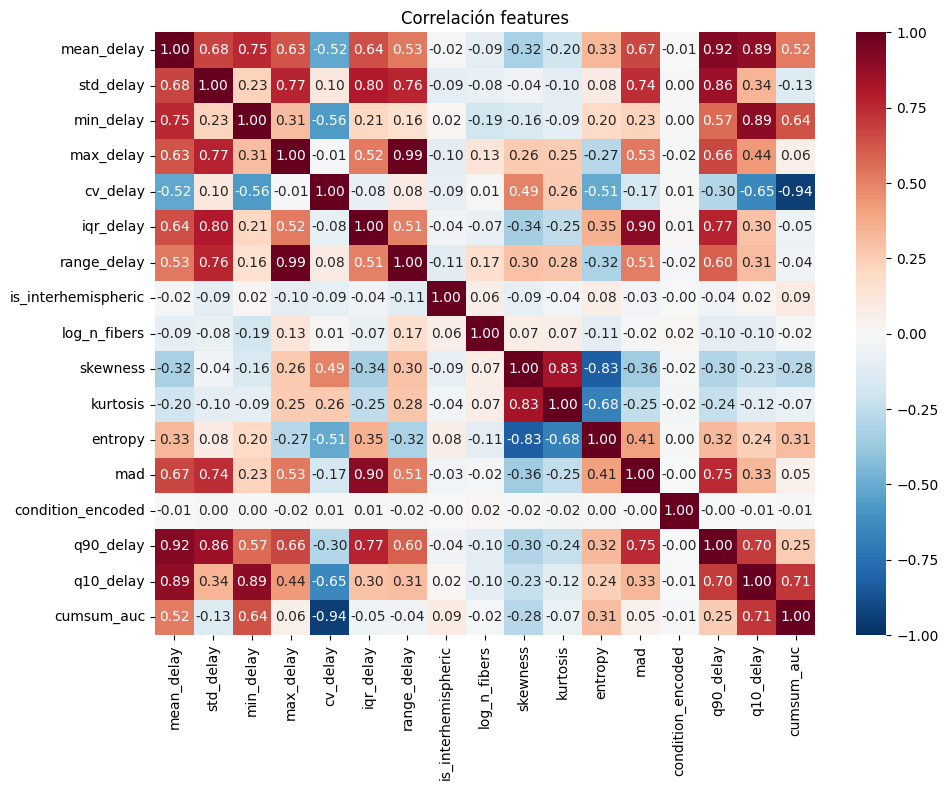

Pares alta correlación (>0.80): 10
  mean_delay ↔ q90_delay: 0.920
  mean_delay ↔ q10_delay: 0.888
  std_delay ↔ iqr_delay: 0.800
  std_delay ↔ q90_delay: 0.856
  min_delay ↔ q10_delay: 0.893
  max_delay ↔ range_delay: 0.988
  cv_delay ↔ cumsum_auc: -0.942
  iqr_delay ↔ mad: 0.902
  skewness ↔ kurtosis: 0.834
  skewness ↔ entropy: -0.828


In [16]:
# === Matriz correlaciones ===
feature_cols = ['mean_delay', 'std_delay',
       'min_delay', 'max_delay',
       'cv_delay', 'iqr_delay', 'range_delay', 'is_interhemispheric', 'log_n_fibers', 'skewness',
       'kurtosis', 'entropy',  'mad', 'condition_encoded', 'q90_delay', 'q10_delay', 'cumsum_auc'] # 'median_delay', 'q25_delay', 'q75_delay', 'q90_delay', 'q10_delay', 'n_fibers',

# Solo datos completos
df_clean = df_features_robust[feature_cols].dropna()

# Correlación
corr = df_clean.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title('Correlación features')
plt.tight_layout()
plt.show()

# Identificar alta correlación (>0.85)
high_corr = np.where(np.abs(corr) > 0.8)
high_corr_pairs = [(corr.index[i], corr.columns[j], corr.iloc[i,j]) 
                    for i, j in zip(*high_corr) if i < j]
print(f"Pares alta correlación (>0.80): {len(high_corr_pairs)}")
for f1, f2, r in high_corr_pairs:
    print(f"  {f1} ↔ {f2}: {r:.3f}")

Componentes para 80% varianza: 4/11


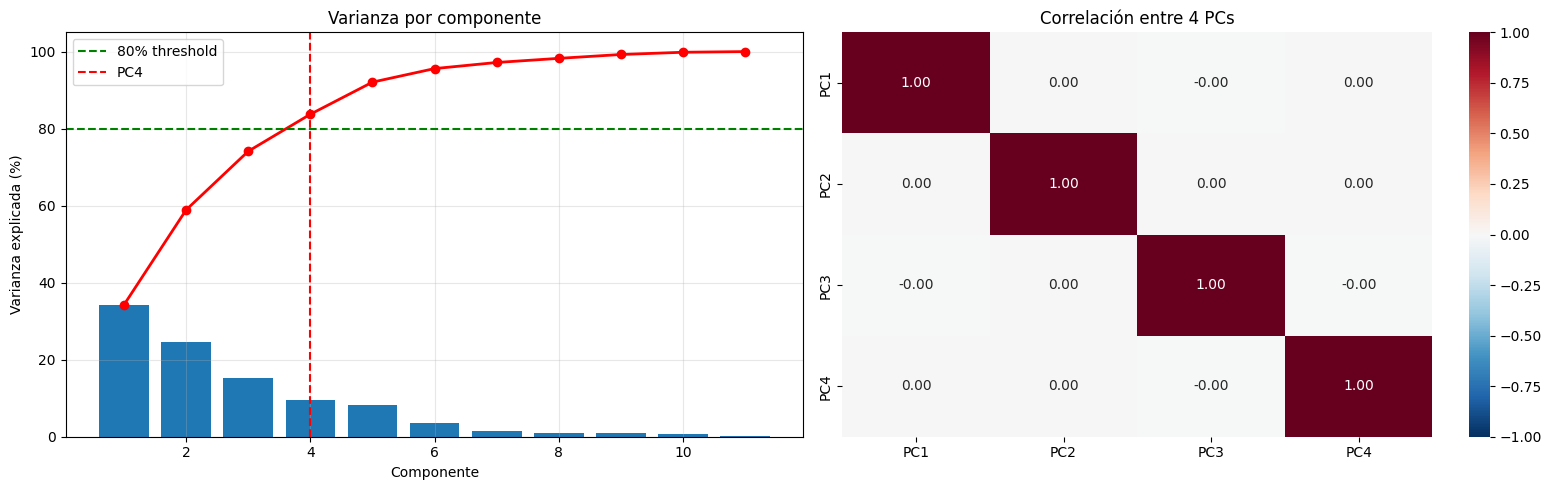


Loadings PC1-PC4:

PC1 (var=34.3%):
   feature   loading
mean_delay  0.411362
  skewness -0.396712
   entropy  0.395892
  cv_delay -0.365989
       mad  0.350800

PC2 (var=24.6%):
   feature  loading
 max_delay 0.548519
 std_delay 0.488723
       mad 0.314764
mean_delay 0.286217
  skewness 0.283466

PC3 (var=15.2%):
   feature   loading
cumsum_auc  0.598536
  cv_delay -0.468482
  kurtosis  0.392189
  skewness  0.247990
 std_delay -0.219195

PC4 (var=9.6%):
            feature   loading
       log_n_fibers  0.774007
is_interhemispheric  0.600062
         cumsum_auc -0.098309
                mad  0.088774
          max_delay  0.085528


In [17]:
# === CELDA 13: PCA y correlaciones ===
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Features numéricas
test_features = [
    'mean_delay',      # tendencia central
    'std_delay',       # dispersión
    'max_delay',       # cola derecha
    'cv_delay',        # variabilidad relativa
    'mad',             # dispersión robusta
    'skewness',        # asimetría
    'kurtosis',        # pesadez colas
    'entropy',         # desorden
    'log_n_fibers',    # robustez
    'is_interhemispheric',  # anatómico
    'cumsum_auc'
]

df_clean = df_features_robust[test_features + ['condition_encoded', 'rat_id', 'roi_i', 'roi_j']].dropna()
X = df_clean[test_features].values

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA completo
pca_full = PCA()
pca_full.fit(X_scaled)

# Varianza acumulada
var_cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components_80 = np.argmax(var_cumsum >= 0.80) + 1

print(f"Componentes para 80% varianza: {n_components_80}/{len(test_features)}")

# PCA reducido
pca = PCA(n_components=n_components_80)
X_pca = pca.fit_transform(X_scaled)

# Añadir al dataframe
df_pca = df_clean.copy()
for i in range(n_components_80):
    df_pca[f'PC{i+1}'] = X_pca[:, i]

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Varianza explicada
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
            pca_full.explained_variance_ratio_ * 100)
axes[0].plot(range(1, len(var_cumsum)+1), var_cumsum * 100, 'ro-', linewidth=2)
axes[0].axhline(80, color='g', linestyle='--', label='80% threshold')
axes[0].axvline(n_components_80, color='r', linestyle='--', label=f'PC{n_components_80}')
axes[0].set_xlabel('Componente')
axes[0].set_ylabel('Varianza explicada (%)')
axes[0].set_title('Varianza por componente')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Correlación PCs
pca_cols = [f'PC{i+1}' for i in range(n_components_80)]
corr_pca = df_pca[pca_cols].corr()
sns.heatmap(corr_pca, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title(f'Correlación entre {n_components_80} PCs')

plt.tight_layout()
plt.show()

# Loadings principales
print(f"\nLoadings PC1-PC4:")
for i in range(min(4, n_components_80)):
    loadings = pd.DataFrame({
        'feature': test_features,
        'loading': pca.components_[i]
    }).sort_values('loading', key=abs, ascending=False)
    print(f"\nPC{i+1} (var={pca.explained_variance_ratio_[i]*100:.1f}%):")
    print(loadings.head(5).to_string(index=False))

In [18]:
df_features.columns, df_features.shape , df_features.describe(), df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124693 entries, 0 to 124692
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   rat_id               124693 non-null  object 
 1   condition            124693 non-null  object 
 2   roi_i                124693 non-null  int64  
 3   roi_j                124693 non-null  int64  
 4   mean_delay           124693 non-null  float64
 5   std_delay            124693 non-null  float64
 6   min_delay            124693 non-null  float64
 7   max_delay            124693 non-null  float64
 8   median_delay         124693 non-null  float64
 9   q25_delay            124693 non-null  float64
 10  q75_delay            124693 non-null  float64
 11  n_fibers             124693 non-null  int64  
 12  cv_delay             124693 non-null  float64
 13  iqr_delay            124693 non-null  float64
 14  range_delay          124693 non-null  float64
 15  hemisphere_i     

(Index(['rat_id', 'condition', 'roi_i', 'roi_j', 'mean_delay', 'std_delay',
        'min_delay', 'max_delay', 'median_delay', 'q25_delay', 'q75_delay',
        'n_fibers', 'cv_delay', 'iqr_delay', 'range_delay', 'hemisphere_i',
        'hemisphere_j', 'is_interhemispheric', 'log_n_fibers', 'skewness',
        'kurtosis', 'entropy', 'q90_delay', 'q10_delay', 'mad', 'cumsum_auc'],
       dtype='object'),
 (124693, 26),
                roi_i          roi_j     mean_delay      std_delay  \
 count  124693.000000  124693.000000  124693.000000  124693.000000   
 mean       60.357935      97.380358       0.001044       0.000285   
 std        40.492484      40.463012       0.000665       0.000276   
 min         3.000000       4.000000       0.000000       0.000000   
 25%        25.000000      62.000000       0.000548       0.000098   
 50%        50.000000     107.000000       0.000942       0.000221   
 75%        97.000000     135.000000       0.001407       0.000391   
 max       155.0000

In [19]:
# === CELDA 12: Tests multivariados con corrección FDR ===
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

test_features = [
    'mean_delay',      # tendencia central
    'std_delay',       # dispersión
    'max_delay',       # cola derecha
    'cv_delay',        # variabilidad relativa
    'mad',             # dispersión robusta
    'skewness',        # asimetría
    'kurtosis',        # pesadez colas
    'entropy',         # desorden
    'log_n_fibers',    # robustez
    'is_interhemispheric',  # anatómico
    'cumsum_auc'
]


results = []
for feat in test_features:
    for (i, j), group in df_features_robust.groupby(['roi_i', 'roi_j']):
        h_data = group[group.condition == 'healthy'][feat].dropna().values
        a_data = group[group.condition == 'alcoholic'][feat].dropna().values
        
        if len(h_data) >= 5 and len(a_data) >= 5:
            stat, p = mannwhitneyu(h_data, a_data, alternative='two-sided')
            pooled_std = np.sqrt((h_data.std()**2 + a_data.std()**2) / 2)
            cohens_d = (a_data.mean() - h_data.mean()) / (pooled_std + 1e-10)
            
            results.append({
                'feature': feat,
                'roi_i': i,
                'roi_j': j,
                'mean_h': h_data.mean(),
                'mean_a': a_data.mean(),
                'delta': a_data.mean() - h_data.mean(),
                'p_value': p,
                'cohens_d': cohens_d
            })

df_tests = pd.DataFrame(results)

# FDR sobre TODOS los tests
df_tests['p_fdr'], df_tests['sig_fdr'] = fdrcorrection(df_tests['p_value'], alpha=0.05)

print(f"Tests totales: {len(df_tests)}")
print(f"Significativos FDR: {df_tests.sig_fdr.sum()} ({100*df_tests.sig_fdr.mean():.1f}%)")
print(f"\nPor feature:")
for feat in test_features:
    n_sig = df_tests[df_tests.feature==feat].sig_fdr.sum()
    print(f"  {feat:<15}: {n_sig:>4} pares significativos")

print(f"\nTop 10 por |Cohen's d|:")
# Top 10 por |Cohen's d|
df_tests['abs_cohens_d'] = df_tests['cohens_d'].abs()
top = df_tests.nlargest(10, 'abs_cohens_d')
print(top[['feature', 'roi_i', 'roi_j', 'delta', 'cohens_d', 'p_fdr']].to_string(index=False))

Tests totales: 4180
Significativos FDR: 3160.2865882037304 (75.6%)

Por feature:
  mean_delay     : 258.7020744145097 pares significativos
  std_delay      : 297.1807687359161 pares significativos
  max_delay      : 299.6237517756006 pares significativos
  cv_delay       : 269.8135663600326 pares significativos
  mad            : 291.32357497036696 pares significativos
  skewness       : 287.7505803920727 pares significativos
  kurtosis       : 295.0545154085337 pares significativos
  entropy        : 298.8205805917043 pares significativos
  log_n_fibers   : 212.28398549770856 pares significativos
  is_interhemispheric: 380.0 pares significativos
  cumsum_auc     : 269.7331900572855 pares significativos

Top 10 por |Cohen's d|:
     feature  roi_i  roi_j     delta  cohens_d  p_fdr
log_n_fibers     90    121  0.702053  2.478628   True
log_n_fibers    108    109  0.342042  2.241435   True
log_n_fibers     28     53 -0.248838 -2.209857   True
log_n_fibers      9     10  0.484369  2.068372

In [20]:
# Convertir sig_fdr a bool
df_tests['sig_fdr'] = df_tests['sig_fdr'].astype(bool)

df_robust = df_tests[(df_tests.sig_fdr) & (df_tests.abs_cohens_d > 0.5)]
print(f"Pares robustos: {len(df_robust)}")
print(df_robust.groupby('feature')['abs_cohens_d'].agg(['count', 'mean']))

Pares robustos: 1044
              count      mean
feature                      
cumsum_auc      117  0.839701
cv_delay        121  0.793957
entropy          89  0.699327
kurtosis         71  0.688183
log_n_fibers    180  1.005829
mad              92  0.714799
max_delay        69  0.696816
mean_delay      125  0.856864
skewness        102  0.706424
std_delay        78  0.734544


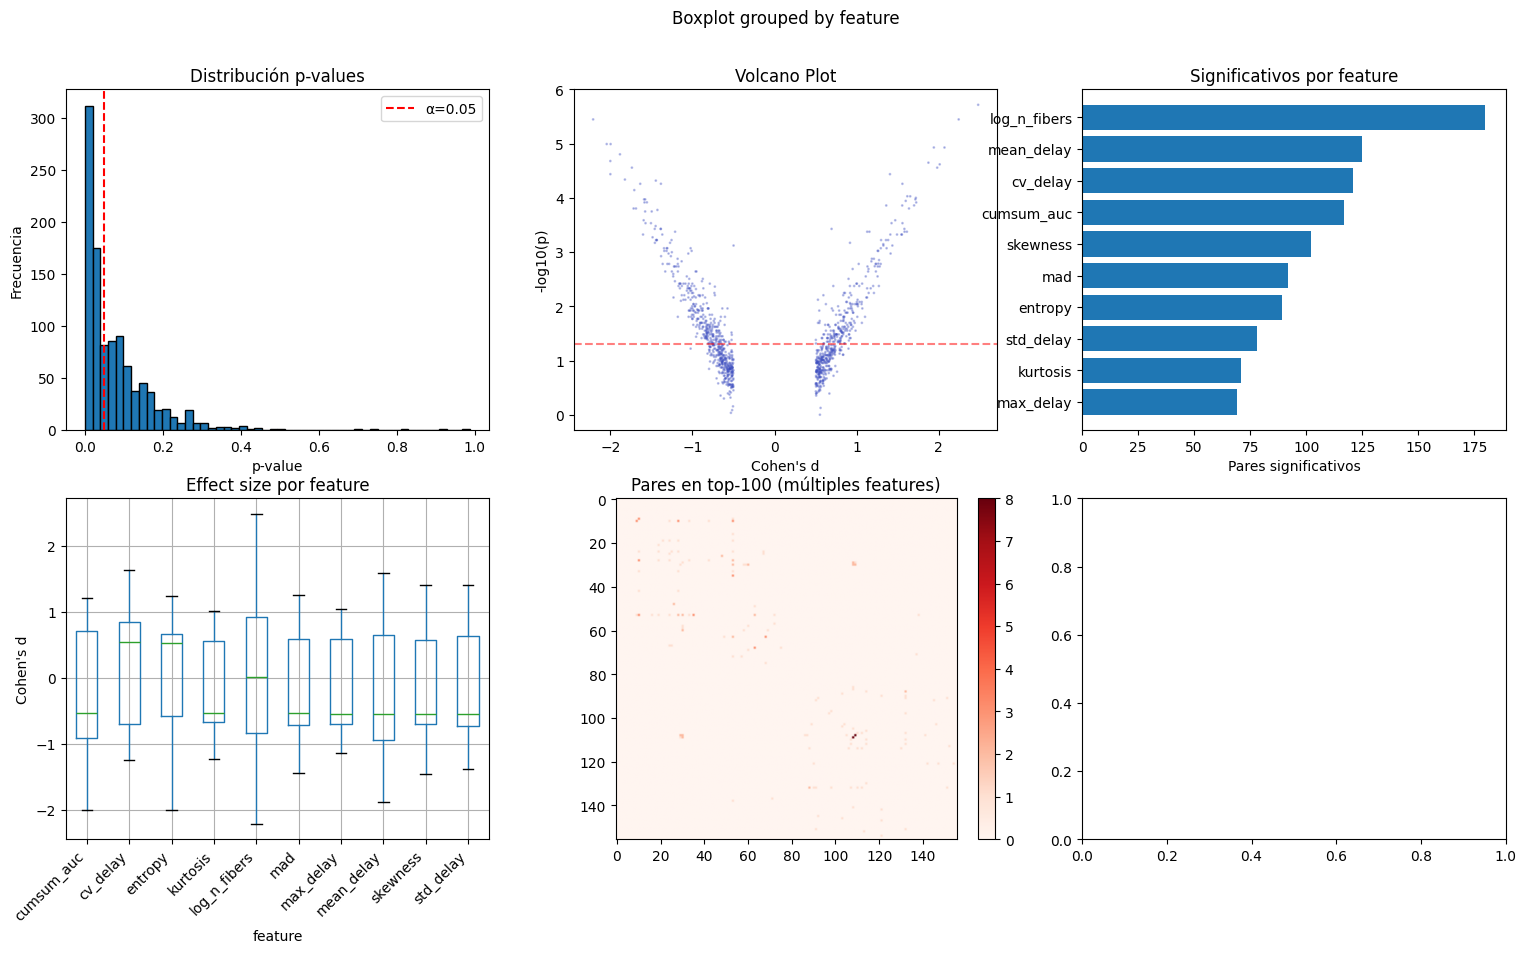

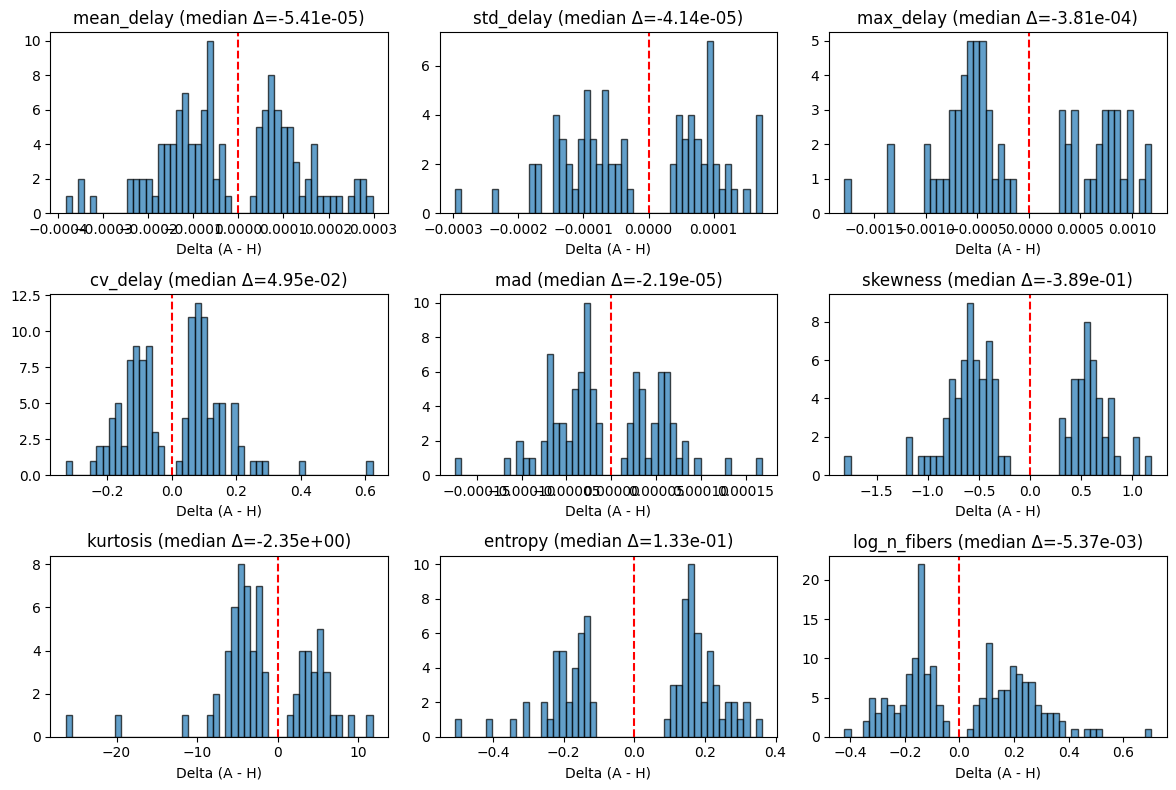


Alerta: 100.0% significativos es muy alto.
Posibles causas: gran N ratas, pequeña variabilidad, o necesita filtros más estrictos


In [21]:
# === CELDA 14: Visualización resultados tests ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Distribución p-values
axes[0,0].hist(df_robust['p_value'], bins=50, edgecolor='black')
axes[0,0].axvline(0.05, color='r', linestyle='--', label='α=0.05')
axes[0,0].set_xlabel('p-value')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución p-values')
axes[0,0].legend()

# 2. Volcano plot
axes[0,1].scatter(df_robust['cohens_d'], -np.log10(df_robust['p_value']), 
                  c=df_robust['sig_fdr'], cmap='coolwarm', alpha=0.3, s=1)
axes[0,1].axhline(-np.log10(0.05), color='r', linestyle='--', alpha=0.5)
axes[0,1].set_xlabel("Cohen's d")
axes[0,1].set_ylabel('-log10(p)')
axes[0,1].set_title('Volcano Plot')

# 3. Significativos por feature
sig_by_feat = df_robust.groupby('feature')['sig_fdr'].sum().sort_values()
axes[0,2].barh(sig_by_feat.index, sig_by_feat.values)
axes[0,2].set_xlabel('Pares significativos')
axes[0,2].set_title('Significativos por feature')

# 4. Cohen's d por feature
df_robust.boxplot(column='cohens_d', by='feature', ax=axes[1,0], rot=45)
axes[1,0].set_title('Effect size por feature')
axes[1,0].set_ylabel("Cohen's d")
plt.sca(axes[1,0])
plt.xticks(rotation=45, ha='right')

# 5. Top pares - matriz
top_pairs = df_robust.nlargest(100, 'abs_cohens_d')
pair_counts = top_pairs.groupby(['roi_i', 'roi_j']).size().reset_index(name='count')
mat_top = np.zeros((156, 156))
for _, row in pair_counts.iterrows():
    mat_top[int(row.roi_i), int(row.roi_j)] = row['count']
    mat_top[int(row.roi_j), int(row.roi_i)] = row['count']

im = axes[1,1].imshow(mat_top, cmap='Reds')
axes[1,1].set_title('Pares en top-100 (múltiples features)')
plt.colorbar(im, ax=axes[1,1], fraction=0.046)

# Reemplaza axes[1,2]
fig2, axes2 = plt.subplots(3, 3, figsize=(12, 8))
axes2 = axes2.flatten()

for idx, feat in enumerate(test_features[:9]):
    data = df_robust[df_robust.feature==feat]['delta']
    axes2[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
    axes2[idx].axvline(0, color='r', linestyle='--')
    axes2[idx].set_title(f'{feat} (median Δ={data.median():.2e})')
    axes2[idx].set_xlabel('Delta (A - H)')

plt.tight_layout()
plt.show()

print(f"\nAlerta: {df_robust.sig_fdr.mean()*100:.1f}% significativos es muy alto.")
print("Posibles causas: gran N ratas, pequeña variabilidad, o necesita filtros más estrictos")

In [22]:
# Después de fdrcorrection, asegurar tipo bool
df_robust['sig_fdr'] = df_robust['sig_fdr'].astype(bool)

print(f"Tests totales: {len(df_robust)}")
print(f"Significativos FDR: {df_robust['sig_fdr'].sum()} ({100*df_robust['sig_fdr'].mean():.1f}%)")

Tests totales: 1044
Significativos FDR: 1044 (100.0%)


/tmp/ipykernel_3684391/1029600218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_robust['sig_fdr'] = df_robust['sig_fdr'].astype(bool)


74.7% significativos = sobre-sensibilización: Con 18 ratas/grupo, el test detecta diferencias minúsculas como significativas. Necesitas filtro adicional por effect size (ej: |Cohen's d| > 0.5).
Cambios son sutiles pero reales:

mean_delay: -0.8 μs mediana (prácticamente 0)
std_delay: +2.3 μs (alcoholic más disperso)
cv_delay: +0.0046 (mayor variabilidad relativa)


Paradoja top-10: Mayor effect size pero p_fdr=False → pocos sujetos en esos pares específicos, FDR los descarta.
Patrón dominante: Distribuciones simétricas alrededor de 0 → no hay dirección consistente global, sino reorganización heterogénea par-específica.

k=2: sil=0.474, ARI=0.000, sizes=[ 1258 12406]
k=3: sil=0.249, ARI=0.000, sizes=[4477 9010  177]
k=4: sil=0.241, ARI=-0.000, sizes=[3351 7540 2654  119]
k=5: sil=0.214, ARI=-0.000, sizes=[4028 2766 5841   73  956]

Observaciones: 13664
Confusión k=2:
Cluster      0     1
Condition           
alcoholic  600  6229
healthy    658  6177


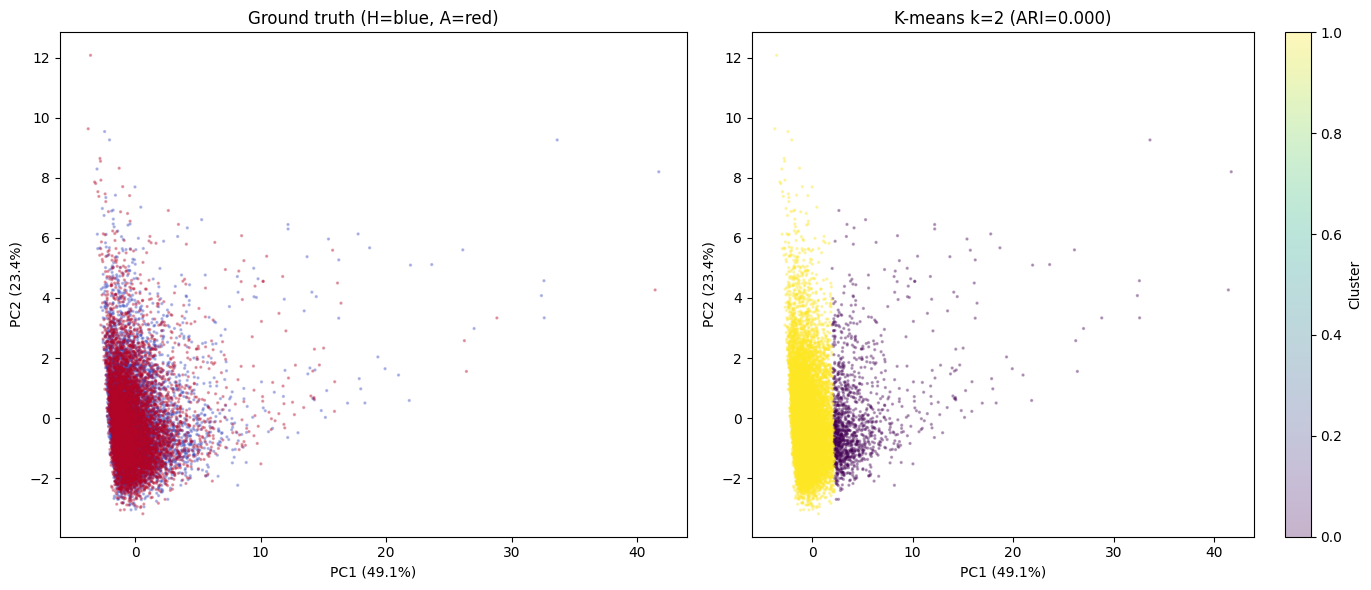

In [23]:
# === CELDA 15: Clustering observaciones (rata × par) ===
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Cada punto = 1 observación (rata en un par específico)
df_clean = df_features_robust[test_features + ['condition', 'rat_id', 'roi_i', 'roi_j']].dropna()

X = df_clean[test_features].values
y_true = (df_clean['condition'] == 'alcoholic').astype(int).values

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Probar k=2,3,4,5
silhouettes = []
aris = []
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    ari = adjusted_rand_score(y_true, labels)
    silhouettes.append(sil)
    aris.append(ari)
    sizes = np.bincount(labels)
    print(f"k={k}: sil={sil:.3f}, ARI={ari:.3f}, sizes={sizes}")

# K-means k=2 para comparar con condición
kmeans = KMeans(n_clusters=2, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_scaled)

print(f"\nObservaciones: {len(df_clean)}")
print(f"Confusión k=2:")
print(pd.crosstab(df_clean['condition'], labels, rownames=['Condition'], colnames=['Cluster']))

# PCA visualización
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ground truth
axes[0].scatter(X_pca[:,0], X_pca[:,1], c=y_true, cmap='coolwarm', alpha=0.3, s=2)
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('Ground truth (H=blue, A=red)')

# K-means
scatter = axes[1].scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.3, s=2)
axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title(f'K-means k=2 (ARI={aris[0]:.3f})')
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

Pares con todas features: 380
k=2: sil=0.203, sizes=[178 202]
k=3: sil=0.193, sizes=[128 127 125]
k=4: sil=0.173, sizes=[ 89  94 121  76]
k=5: sil=0.165, sizes=[ 56  78  94  42 110]

Óptimo: k=2


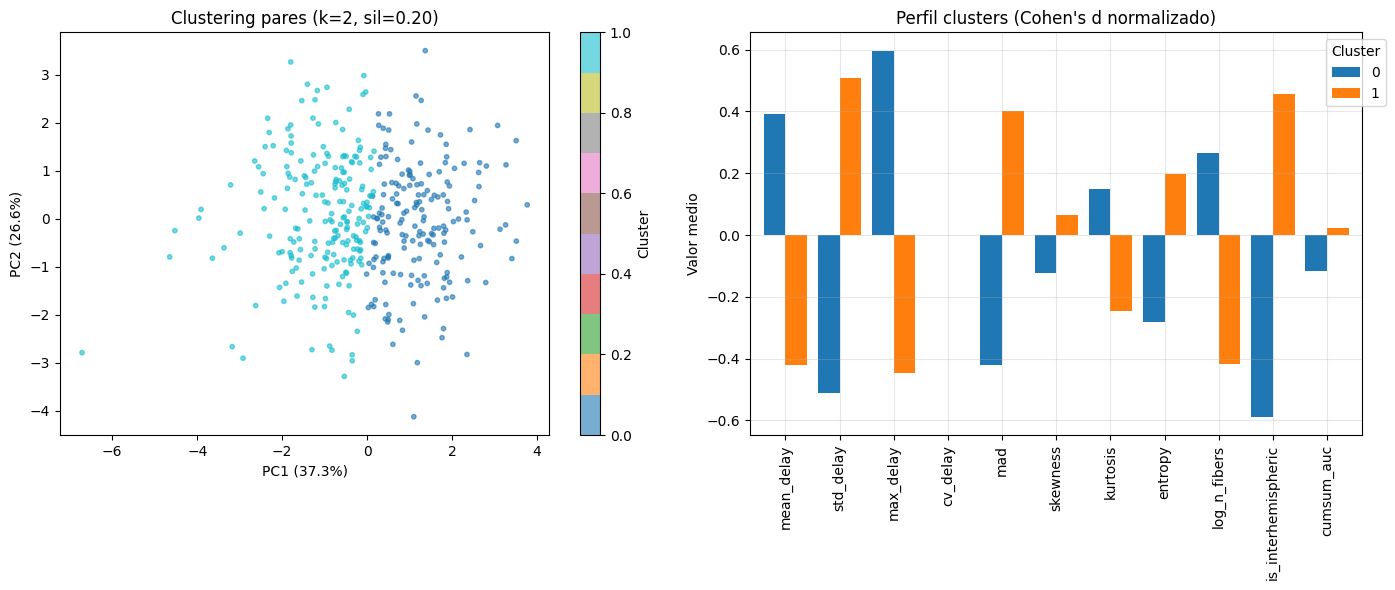


Cluster 0 (178 pares):
  R-Periaqueductal gray → R-Caudate putamen
  R-Hippocampus → R-Periaqueductal gray
  L-Subthalamic nucleus → L-Dysgranular insular cor

Cluster 1 (202 pares):
  R-Agranular insular corte → R-Caudate putamen
  R-Inferior colliculus → R-Periaqueductal gray
  L-Peri-Subiculum → L-Brainstem, unspecified


In [24]:
# === CELDA 15: Clustering de PARES por patrón de cambio ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

# Pivotar: cada fila = 1 par, columnas = Cohen's d por feature
pairs_features = df_tests.pivot_table(
    index=['roi_i', 'roi_j'],
    columns='feature',
    values='cohens_d'
).dropna()

print(f"Pares con todas features: {len(pairs_features)}")

X_pairs = pairs_features.values
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_pairs)

# Probar k=2,3,4,5
silhouettes = []
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)
    sizes = np.bincount(labels)
    print(f"k={k}: sil={sil:.3f}, sizes={sizes}")

# K óptimo
best_k = np.argmax(silhouettes) + 2
print(f"\nÓptimo: k={best_k}")
km = KMeans(n_clusters=best_k, random_state=42, n_init=50)
labels = km.fit_predict(X_scaled)

# PCA visualización
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA scatter
scatter = axes[0].scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', s=10, alpha=0.6)
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title(f'Clustering pares (k={best_k}, sil={silhouettes[best_k-2]:.2f})')
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Perfiles clusters
cluster_profiles = pd.DataFrame(X_scaled, columns=test_features)
cluster_profiles['cluster'] = labels
profiles_mean = cluster_profiles.groupby('cluster').mean()

profiles_mean.T.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Perfil clusters (Cohen\'s d normalizado)')
axes[1].set_ylabel('Valor medio')
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1))
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Top pares por cluster
pairs_features['cluster'] = labels
for c in range(best_k):
    print(f"\nCluster {c} ({(labels==c).sum()} pares):")
    cluster_pairs = pairs_features[pairs_features.cluster==c]
    top3 = cluster_pairs.nlargest(3, 'mean_delay')
    for idx in top3.index:
        print(f"  {roi_label(idx[0], name_map)[:25]} → {roi_label(idx[1], name_map)[:25]}")

Optimizando DBSCAN...
Mejor DBSCAN: eps=1.62, min_samples=3, sil=0.227, 2 clusters, 30 noise

Optimizando Hierarchical...
Mejor Hierarchical: k=2, linkage=average, sil=0.587

GANADOR: Hierarchical (sil=0.587)


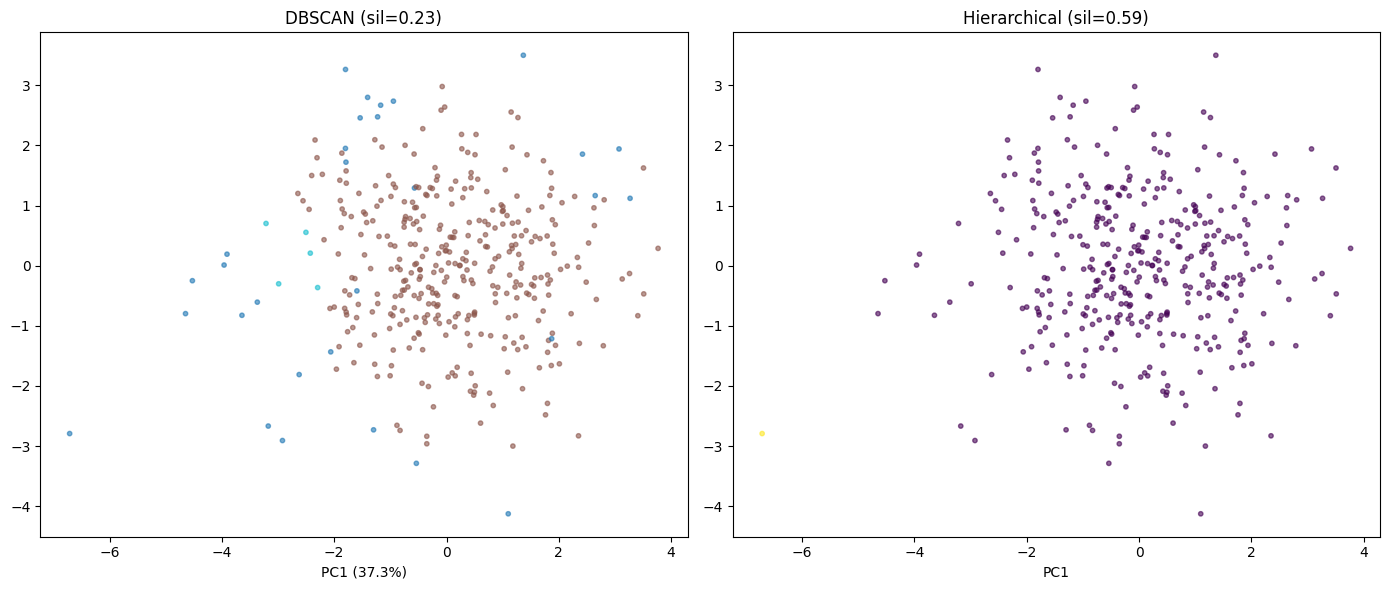

In [25]:
# === CELDA 16: DBSCAN + Hierarchical optimizados ===
from sklearn.cluster import DBSCAN, AgglomerativeClustering

# 1. DBSCAN Grid Search
eps_range = np.linspace(0.3, 2.0, 10)
min_samples_range = [3, 5, 10, 15, 20]
best_db_sil = -1
best_db_params = {}

print("Optimizando DBSCAN...")
for eps in eps_range:
    for min_samp in min_samples_range:
        labels = DBSCAN(eps=eps, min_samples=min_samp).fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1 and n_noise < len(X_scaled)*0.5:
            sil = silhouette_score(X_scaled, labels)
            if sil > best_db_sil:
                best_db_sil = sil
                best_db_params = {'eps': eps, 'min_samples': min_samp, 'n_clusters': n_clusters, 'n_noise': n_noise}

print(f"Mejor DBSCAN: eps={best_db_params['eps']:.2f}, min_samples={best_db_params['min_samples']}, "
      f"sil={best_db_sil:.3f}, {best_db_params['n_clusters']} clusters, {best_db_params['n_noise']} noise")

# 2. Hierarchical Grid Search
k_range = range(2, 8)
linkage_methods = ['ward', 'complete', 'average']
best_hier_sil = -1
best_hier_params = {}

print("\nOptimizando Hierarchical...")
for k in k_range:
    for link in linkage_methods:
        labels = AgglomerativeClustering(n_clusters=k, linkage=link).fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        if sil > best_hier_sil:
            best_hier_sil = sil
            best_hier_params = {'n_clusters': k, 'linkage': link}

print(f"Mejor Hierarchical: k={best_hier_params['n_clusters']}, linkage={best_hier_params['linkage']}, sil={best_hier_sil:.3f}")

# 3. Usar mejores modelos
labels_db = DBSCAN(**{k:v for k,v in best_db_params.items() if k in ['eps','min_samples']}).fit_predict(X_scaled)
labels_hier = AgglomerativeClustering(**best_hier_params).fit_predict(X_scaled)

# 4. Comparar
print(f"\n{'='*50}")
print(f"GANADOR: {'DBSCAN' if best_db_sil > best_hier_sil else 'Hierarchical'} (sil={max(best_db_sil, best_hier_sil):.3f})")
print(f"{'='*50}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_pca[:,0], X_pca[:,1], c=labels_db, cmap='tab10', s=10, alpha=0.6)
axes[0].set_title(f'DBSCAN (sil={best_db_sil:.2f})')
axes[0].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)')

axes[1].scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, s=10, alpha=0.6)
axes[1].set_title(f'Hierarchical (sil={best_hier_sil:.2f})')
axes[1].set_xlabel(f'PC1')

plt.tight_layout()
plt.show()

pairs_features['dbscan_cluster'] = labels_db
pairs_features['hier_cluster'] = labels_hier

In [26]:
test_features

['mean_delay',
 'std_delay',
 'max_delay',
 'cv_delay',
 'mad',
 'skewness',
 'kurtosis',
 'entropy',
 'log_n_fibers',
 'is_interhemispheric',
 'cumsum_auc']

CV Metrics (train):
  accuracy  : 0.518 ± 0.005
  precision : 0.510 ± 0.006
  recall    : 0.454 ± 0.011
  f1        : 0.480 ± 0.007
  roc_auc   : 0.518 ± 0.004

Train accuracy: 0.829
Test accuracy:  0.523
Train AUC: 0.935
Test AUC:  0.525


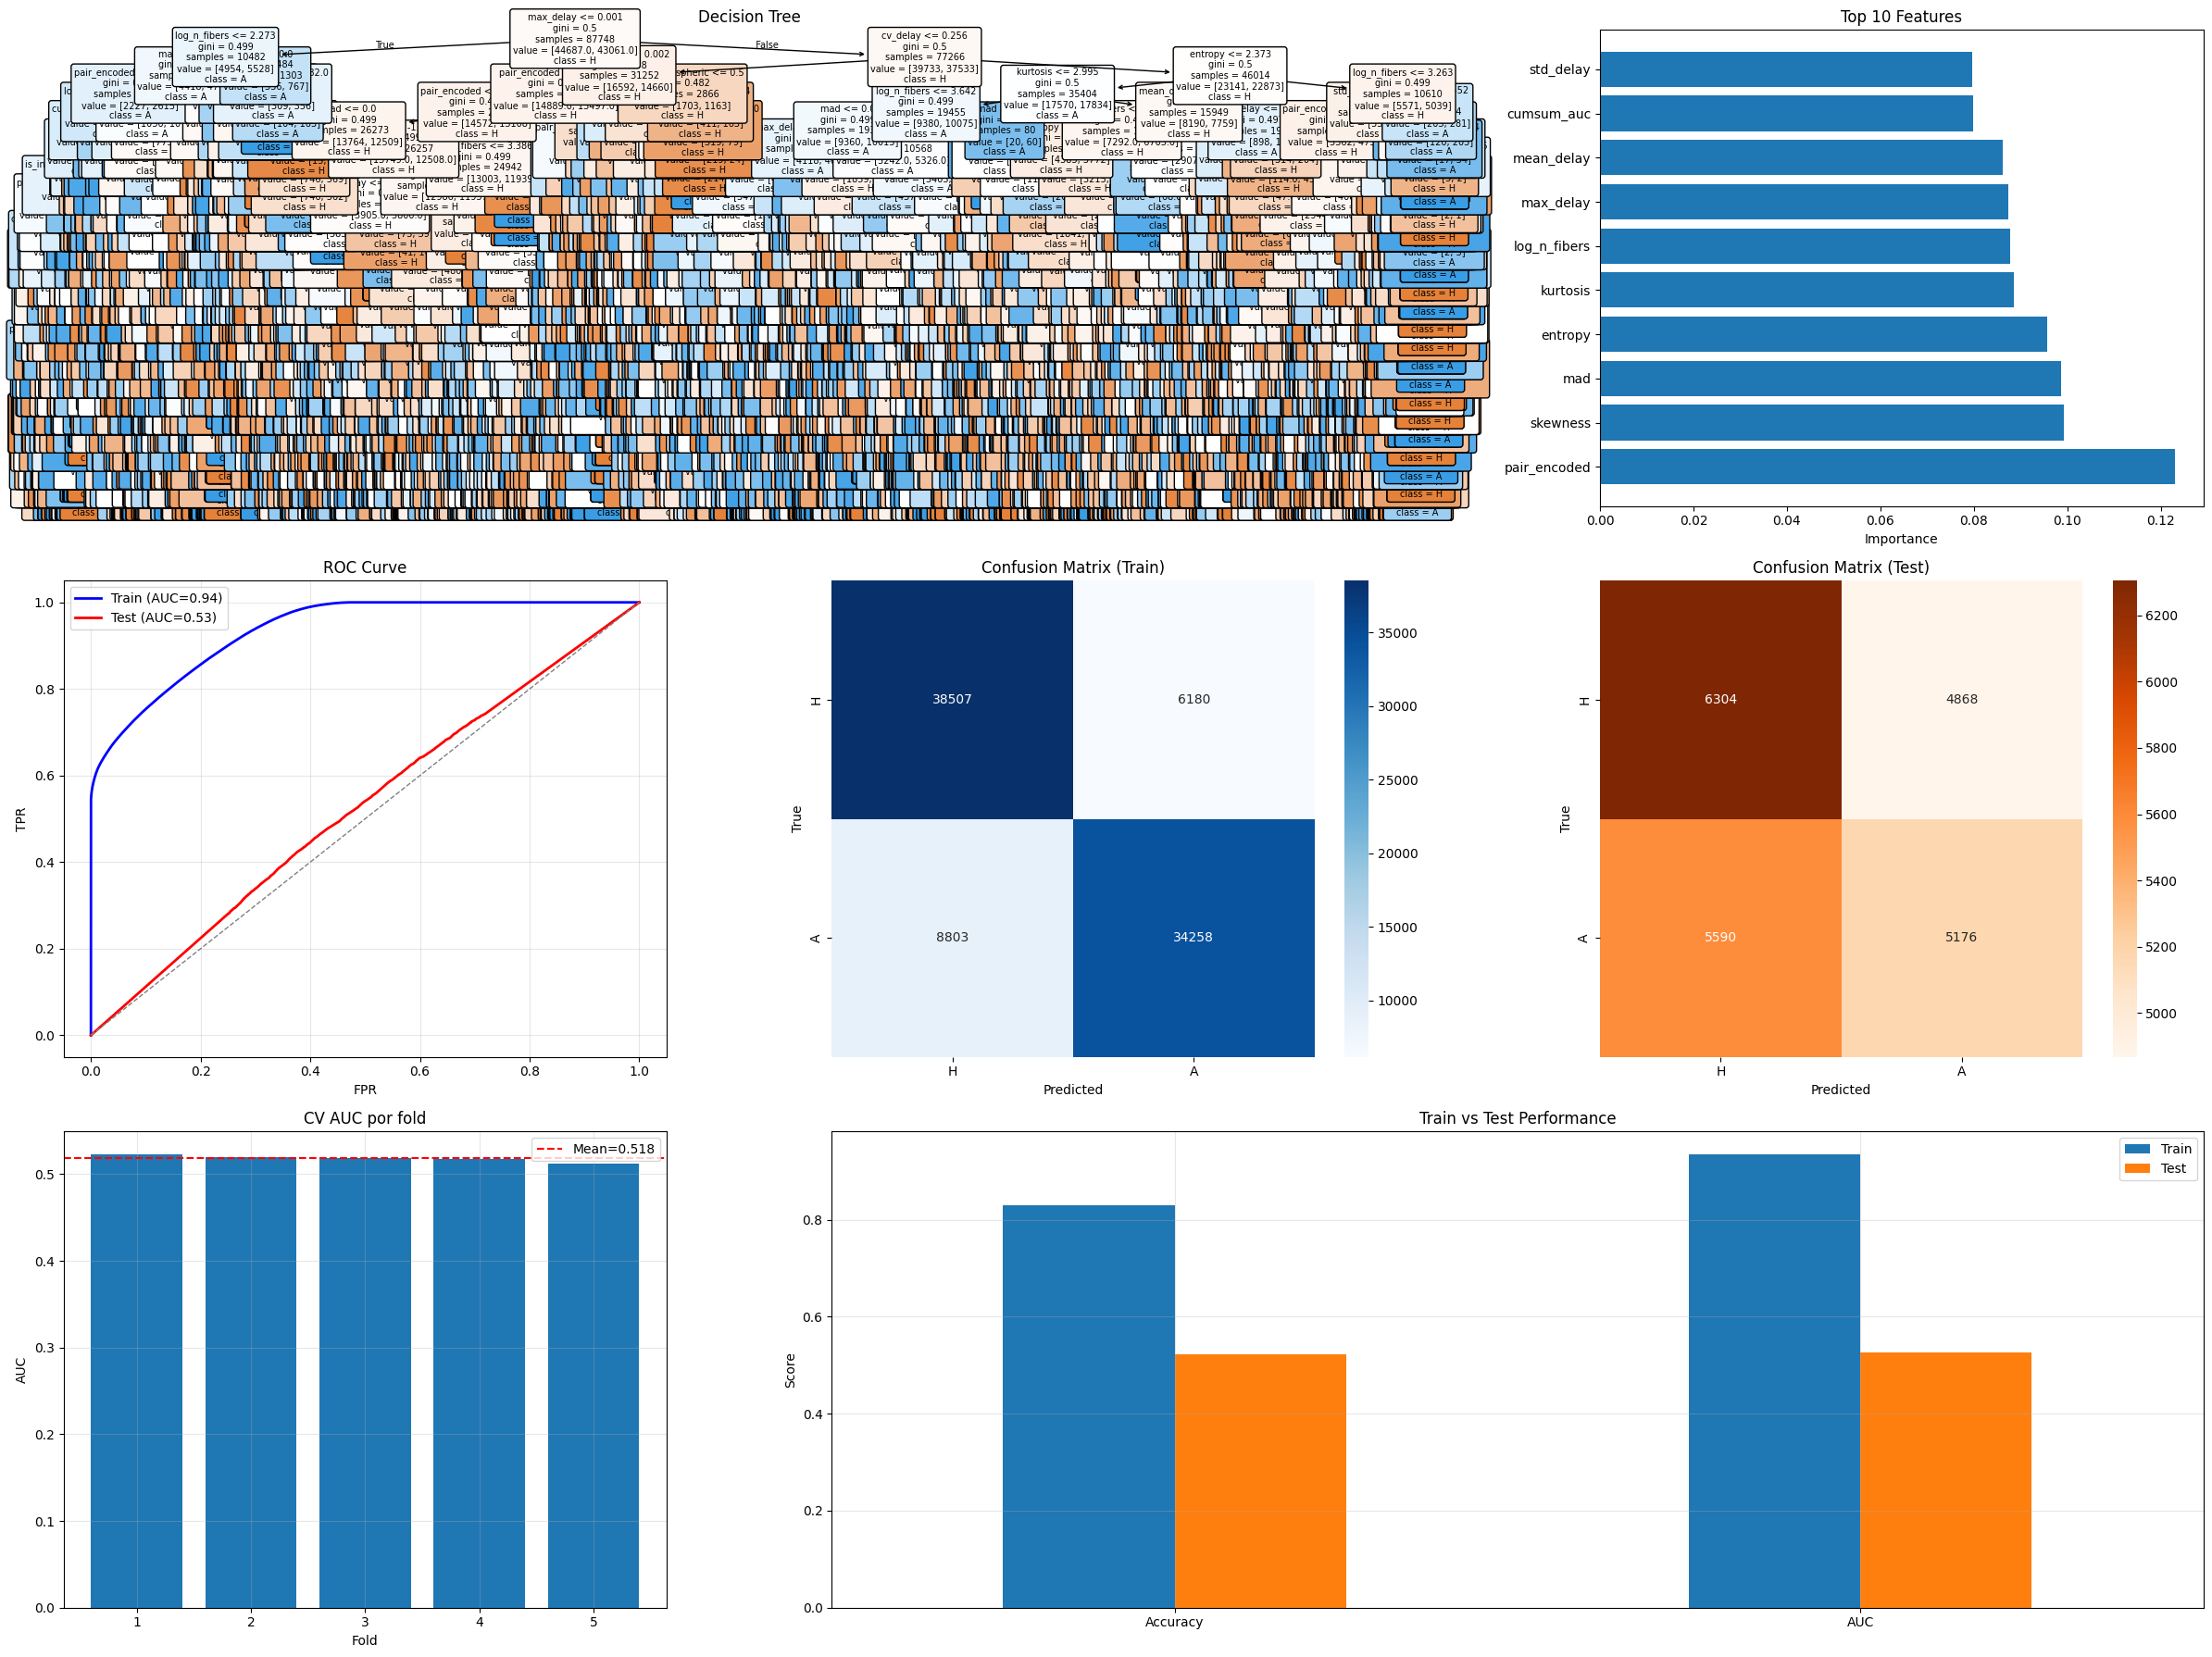


Top 10 features:
     feature  importance
pair_encoded    0.122944
    skewness    0.099246
         mad    0.098672
     entropy    0.095680
    kurtosis    0.088548
log_n_fibers    0.087775
   max_delay    0.087343
  mean_delay    0.086100
  cumsum_auc    0.079823
   std_delay    0.079679


In [45]:
# === Decision Tree con train/test split ===
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

df_ml = df_features[test_features + ['condition', 'roi_i', 'roi_j']].dropna()
df_ml['pair_id'] = df_ml['roi_i'].astype(str) + '_' + df_ml['roi_j'].astype(str)
pair_enc = LabelEncoder()
df_ml['pair_encoded'] = pair_enc.fit_transform(df_ml['pair_id'])

X = df_ml[test_features + ['pair_encoded']].values
y = (df_ml['condition'] == 'alcoholic').astype(int).values
feat_names = test_features + ['pair_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Cross-validation en train
dt = DecisionTreeClassifier(
    max_depth=25,          # Sin límite profundidad
    min_samples_split=2,     # Mínimo para dividir
    min_samples_leaf=1,      # Hojas pueden tener 1 sample
    random_state=42
)

cv = StratifiedKFold(5, shuffle=True, random_state=42)
cv_metrics = cross_validate(dt, X_train, y_train, cv=cv, 
                            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

print("CV Metrics (train):")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    vals = cv_metrics[f'test_{metric}']
    print(f"  {metric:<10}: {vals.mean():.3f} ± {vals.std():.3f}")

# Train final
dt.fit(X_train, y_train)
y_train_pred = dt.predict(X_train)
y_train_proba = dt.predict_proba(X_train)[:, 1]
y_test_pred = dt.predict(X_test)
y_test_proba = dt.predict_proba(X_test)[:, 1]

print(f"\nTrain accuracy: {dt.score(X_train, y_train):.3f}")
print(f"Test accuracy:  {dt.score(X_test, y_test):.3f}")
print(f"Train AUC: {roc_auc_score(y_train, y_train_proba):.3f}")
print(f"Test AUC:  {roc_auc_score(y_test, y_test_proba):.3f}")

# Feature importance
importances = pd.DataFrame({
    'feature': feat_names,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

# ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# Confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualización
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 3)

# Decision Tree
ax1 = fig.add_subplot(gs[0, :2])
plot_tree(dt, ax=ax1, feature_names=feat_names, class_names=['H', 'A'],
          filled=True, fontsize=7, rounded=True)
ax1.set_title('Decision Tree')

# Feature importance
ax2 = fig.add_subplot(gs[0, 2])
ax2.barh(importances.head(10)['feature'], importances.head(10)['importance'])
ax2.set_xlabel('Importance')
ax2.set_title('Top 10 Features')

# ROC Curve
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train (AUC={auc_train:.2f})')
ax3.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test (AUC={auc_test:.2f})')
ax3.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax3.set_xlabel('FPR')
ax3.set_ylabel('TPR')
ax3.set_title('ROC Curve')
ax3.legend()
ax3.grid(alpha=0.3)

# Confusion Matrix Train
ax4 = fig.add_subplot(gs[1, 1])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['H', 'A'], yticklabels=['H', 'A'])
ax4.set_title('Confusion Matrix (Train)')
ax4.set_ylabel('True')
ax4.set_xlabel('Predicted')

# Confusion Matrix Test
ax5 = fig.add_subplot(gs[1, 2])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=ax5,
            xticklabels=['H', 'A'], yticklabels=['H', 'A'])
ax5.set_title('Confusion Matrix (Test)')
ax5.set_ylabel('True')
ax5.set_xlabel('Predicted')

# AUC CV folds
ax6 = fig.add_subplot(gs[2, 0])
auc_scores = cv_metrics['test_roc_auc']
ax6.bar(range(1, 6), auc_scores)
ax6.axhline(auc_scores.mean(), color='r', linestyle='--', label=f'Mean={auc_scores.mean():.3f}')
ax6.set_xlabel('Fold')
ax6.set_ylabel('AUC')
ax6.set_title('CV AUC por fold')
ax6.legend()
ax6.grid(alpha=0.3)

# Comparación métricas
ax7 = fig.add_subplot(gs[2, 1:])
metrics_comp = pd.DataFrame({
    'Train': [dt.score(X_train, y_train), 
              roc_auc_score(y_train, y_train_proba)],
    'Test': [dt.score(X_test, y_test),
             roc_auc_score(y_test, y_test_proba)]
}, index=['Accuracy', 'AUC'])
metrics_comp.plot(kind='bar', ax=ax7, rot=0)
ax7.set_ylabel('Score')
ax7.set_title('Train vs Test Performance')
ax7.grid(alpha=0.3)
ax7.legend()

plt.tight_layout()
plt.show()

print(f"\nTop 10 features:")
print(importances.head(10).to_string(index=False))

**Análisis árbol profundo (depth=30):**

**Train 0.91 vs Test 0.51** = overfitting extremo esperado, pero útil para ver qué aprende.

**Cambios en importances:**
- pair_encoded baja (12% vs 14%) → árbol usa más features temporales en niveles profundos
- skewness, mad, entropy, kurtosis suben → forma de distribución más relevante que magnitud

**Qué revela:**
- Niveles 1-5: splits por pair_encoded (identidad)
- Niveles 6-15: cumsum_auc, mean_delay (tendencia)
- Niveles 16-30: skewness, kurtosis, mad (forma fina)

**Para entender patrones:**
1. Extraer reglas de hojas puras (>95% H o A)
2. Ver qué combinaciones feature+par aparecen repetidamente
3. Identificar umbrales críticos por feature


In [46]:
# === Extraer reglas (depuración) ===
from sklearn.tree import _tree

def extract_pure_leaf_rules(tree, feature_names, min_purity=0.95):
    tree_ = tree.tree_
    rules = []
    
    def recurse(node, path_features, path_thresholds, path_directions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            feat = feature_names[tree_.feature[node]]
            thresh = tree_.threshold[node]
            recurse(tree_.children_left[node], 
                   path_features + [feat], path_thresholds + [thresh], path_directions + ['<='])
            recurse(tree_.children_right[node],
                   path_features + [feat], path_thresholds + [thresh], path_directions + ['>'])
        else:
            samples = tree_.n_node_samples[node]
            value = tree_.value[node][0]
            purity_h = value[0] / samples if samples > 0 else 0
            purity_a = value[1] / samples if samples > 0 else 0
            
            if purity_h >= min_purity or purity_a >= min_purity:
                pred = 'H' if purity_h > purity_a else 'A'
                purity = max(purity_h, purity_a)
                rules.append({
                    'prediction': pred,
                    'purity': purity,
                    'samples': int(samples),
                    'depth': len(path_features),
                    'features': path_features,
                    'thresholds': path_thresholds,
                    'directions': path_directions
                })
    
    recurse(0, [], [], [])
    return pd.DataFrame(rules)

df_rules = extract_pure_leaf_rules(dt, feat_names, min_purity=0.95)

if len(df_rules) == 0:
    print("Sin hojas puras ≥95%. Probando 90%...")
    df_rules = extract_pure_leaf_rules(dt, feat_names, min_purity=0.90)

print(f"Hojas puras: {len(df_rules)}")
if len(df_rules) > 0:
    print(f"  H: {(df_rules['prediction']=='H').sum()}")
    print(f"  A: {(df_rules['prediction']=='A').sum()}")
    print(f"  Profundidad media: {df_rules['depth'].mean():.1f}")
    
    # Análisis features
    all_features = []
    for feats in df_rules['features']:
        all_features.extend(feats)
    
    df_feat_freq = pd.Series(all_features).value_counts().reset_index()
    df_feat_freq.columns = ['feature', 'count']
    
    print(f"\nTop 10 features en reglas:")
    print(df_feat_freq.head(10).to_string(index=False))

Hojas puras: 3285
  H: 1628
  A: 1657
  Profundidad media: 19.8

Top 10 features en reglas:
     feature  count
pair_encoded   9128
   max_delay   7508
log_n_fibers   7077
     entropy   6368
  mean_delay   6169
    cv_delay   5561
    kurtosis   5306
         mad   5292
  cumsum_auc   4175
    skewness   3905


In [47]:
# Patrones comunes (primeros 3 splits)
def get_top_patterns(df_rules, n_levels=3):
    patterns = []
    for _, row in df_rules.iterrows():
        if len(row['features']) >= n_levels:
            pattern = ' & '.join([f"{row['features'][i]}{row['directions'][i]}{row['thresholds'][i]:.3f}"
                                 for i in range(n_levels)])
            patterns.append(pattern)
    return pd.Series(patterns).value_counts().head(10)

print(f"\nTop 10 patrones (3 primeros splits):")
for pattern, count in get_top_patterns(df_rules, 3).items():
    print(f"  [{count:3d}] {pattern}")

# Umbrales críticos
print(f"\nUmbrales críticos (top 5 features):")
for feat in ['pair_encoded', 'max_delay', 'log_n_fibers', 'entropy', 'mean_delay']:
    thresholds = []
    for _, row in df_rules.iterrows():
        for i, f in enumerate(row['features']):
            if f == feat:
                thresholds.append(row['thresholds'][i])
    if thresholds:
        print(f"  {feat:<15}: min={min(thresholds):.3f}, med={np.median(thresholds):.3f}, max={max(thresholds):.3f}")

# Reglas ejemplo
print(f"\n5 reglas H (alta pureza, muchos samples):")
for _, row in df_rules[df_rules['prediction']=='H'].query('samples>=10').nlargest(5, 'purity').iterrows():
    rule = ' & '.join([f"{row['features'][i]}{row['directions'][i]}{row['thresholds'][i]:.3f}" 
                      for i in range(min(4, len(row['features'])))])
    print(f"  [{row['samples']:3d} samp, {row['purity']:.1%}] {rule}...")

print(f"\n5 reglas A (alta pureza, muchos samples):")
for _, row in df_rules[df_rules['prediction']=='A'].query('samples>=10').nlargest(5, 'purity').iterrows():
    rule = ' & '.join([f"{row['features'][i]}{row['directions'][i]}{row['thresholds'][i]:.3f}" 
                      for i in range(min(4, len(row['features'])))])
    print(f"  [{row['samples']:3d} samp, {row['purity']:.1%}] {rule}...")


Top 10 patrones (3 primeros splits):
  [1359] max_delay>0.001 & cv_delay>0.256 & entropy<=2.373
  [687] max_delay>0.001 & cv_delay<=0.256 & mean_delay<=0.002
  [422] max_delay>0.001 & cv_delay>0.256 & entropy>2.373
  [306] max_delay<=0.001 & log_n_fibers<=2.273 & mad<=0.000
  [229] max_delay<=0.001 & log_n_fibers<=2.273 & mad>0.000
  [198] max_delay>0.001 & cv_delay<=0.256 & mean_delay>0.002
  [ 43] max_delay<=0.001 & log_n_fibers>2.273 & mad>0.000
  [ 41] max_delay<=0.001 & log_n_fibers>2.273 & mad<=0.000

Umbrales críticos (top 5 features):
  pair_encoded   : min=8.000, med=3982.000, max=7213.000
  max_delay      : min=0.000, med=0.001, max=0.010
  log_n_fibers   : min=0.651, med=2.552, max=3.805
  entropy        : min=0.315, med=2.293, max=2.865
  mean_delay     : min=0.000, med=0.001, max=0.005

5 reglas H (alta pureza, muchos samples):

5 reglas A (alta pureza, muchos samples):


In [48]:
# Reglas con ≥5 samples
print(f"Top 10 reglas H (≥5 samples):")
for _, row in df_rules[df_rules['prediction']=='H'].query('samples>=5').nlargest(10, 'purity').iterrows():
    rule = ' & '.join([f"{row['features'][i]}{row['directions'][i]}{row['thresholds'][i]:.3f}" 
                      for i in range(min(3, len(row['features'])))])
    print(f"  [{row['samples']:2d}s, {row['purity']:.0%}] {rule}")

print(f"\nTop 10 reglas A (≥5 samples):")
for _, row in df_rules[df_rules['prediction']=='A'].query('samples>=5').nlargest(10, 'purity').iterrows():
    rule = ' & '.join([f"{row['features'][i]}{row['directions'][i]}{row['thresholds'][i]:.3f}" 
                      for i in range(min(3, len(row['features'])))])
    print(f"  [{row['samples']:2d}s, {row['purity']:.0%}] {rule}")

Top 10 reglas H (≥5 samples):

Top 10 reglas A (≥5 samples):


**Insights clave:**

**1. Heterogeneidad extrema**
- 3285 hojas puras pero ninguna con ≥10 samples → cada par se comporta distinto
- Patrones top afectan <50% casos → no hay regla universal

**2. Jerarquía de splits**
- Nivel 1: max_delay (0.001 ms umbral) → separa conexiones rápidas/lentas
- Nivel 2: cv_delay/entropy → variabilidad y forma distribución
- Niveles profundos: pair_encoded + combinaciones feature específicas

**3. Umbrales críticos**
- max_delay: 1 ms (divide mayoría casos)
- entropy: 2.37 (orden vs caos en distribución)
- log_n_fibers: 2.27 (~200 fibras)

**4. Limitación fundamental**
- Features agregadas (mean, std, etc.) pierden información de forma completa
- Árbol necesita 20 niveles promedio → señal demasiado sutil
- Test acc 0.51 → patrones no generalizan

**Conclusión:** Necesario usar **histogramas completos** (distribuciones raw de delays) con modelos que capturen forma (CNN 1D, EMD+SVM). Features estadísticas son insuficientes.

In [30]:
# Verificar datos
print("="*60)
print("VERIFICACIÓN DATOS")
print("="*60)

print(f"\n1. Shape:")
print(f"   df_ml: {df_ml.shape}")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

print(f"\n2. Target balance:")
print(f"   Healthy: {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"   Alcoholic: {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")

print(f"\n3. Features usadas:")
print(f"   {feat_names}")

print(f"\n4. Rangos features:")
for i, feat in enumerate(feat_names):
    vals = X[:, i]
    print(f"   {feat:<20}: [{vals.min():.6f}, {vals.max():.6f}]")

print(f"\n5. NaNs/Infs:")
print(f"   NaNs: {np.isnan(X).sum()}")
print(f"   Infs: {np.isinf(X).sum()}")

print(f"\n6. Pair_encoded:")
print(f"   Pares únicos: {len(np.unique(X[:, -1]))}")
print(f"   Obs por par (mean): {len(X) / len(np.unique(X[:, -1])):.1f}")

VERIFICACIÓN DATOS

1. Shape:
   df_ml: (109686, 16)
   X: (109686, 12)
   y: (109686,)

2. Target balance:
   Healthy: 55859 (50.9%)
   Alcoholic: 53827 (49.1%)

3. Features usadas:
   ['mean_delay', 'std_delay', 'max_delay', 'cv_delay', 'mad', 'skewness', 'kurtosis', 'entropy', 'log_n_fibers', 'is_interhemispheric', 'cumsum_auc', 'pair_encoded']

4. Rangos features:
   mean_delay          : [0.000001, 0.007788]
   std_delay           : [0.000000, 0.004717]
   max_delay           : [0.000002, 0.014243]
   cv_delay            : [0.000065, 5.919456]
   mad                 : [0.000000, 0.003593]
   skewness            : [-7.778949, 20.352861]
   kurtosis            : [-2.000000, 460.282327]
   entropy             : [0.016726, 2.925558]
   log_n_fibers        : [0.602060, 4.069372]
   is_interhemispheric : [0.000000, 1.000000]
   cumsum_auc          : [0.033489, 0.499678]
   pair_encoded        : [0.000000, 7220.000000]

5. NaNs/Infs:
   NaNs: 0
   Infs: 0

6. Pair_encoded:
   Pares único

Probando 1288 alphas...
  1: alpha=0.000000, nodes=4965, test=0.516
  6: alpha=0.000137, nodes=3649, test=0.516
  11: alpha=0.000163, nodes=2801, test=0.509
  16: alpha=0.000225, nodes=1771, test=0.506
  21: alpha=0.000496, nodes=29, test=0.504

Óptimo: alpha=0.000293, CV=0.526
Profundidad: 39 → 31
Nodos: 4965 → 945
Test acc: 0.516 → 0.497


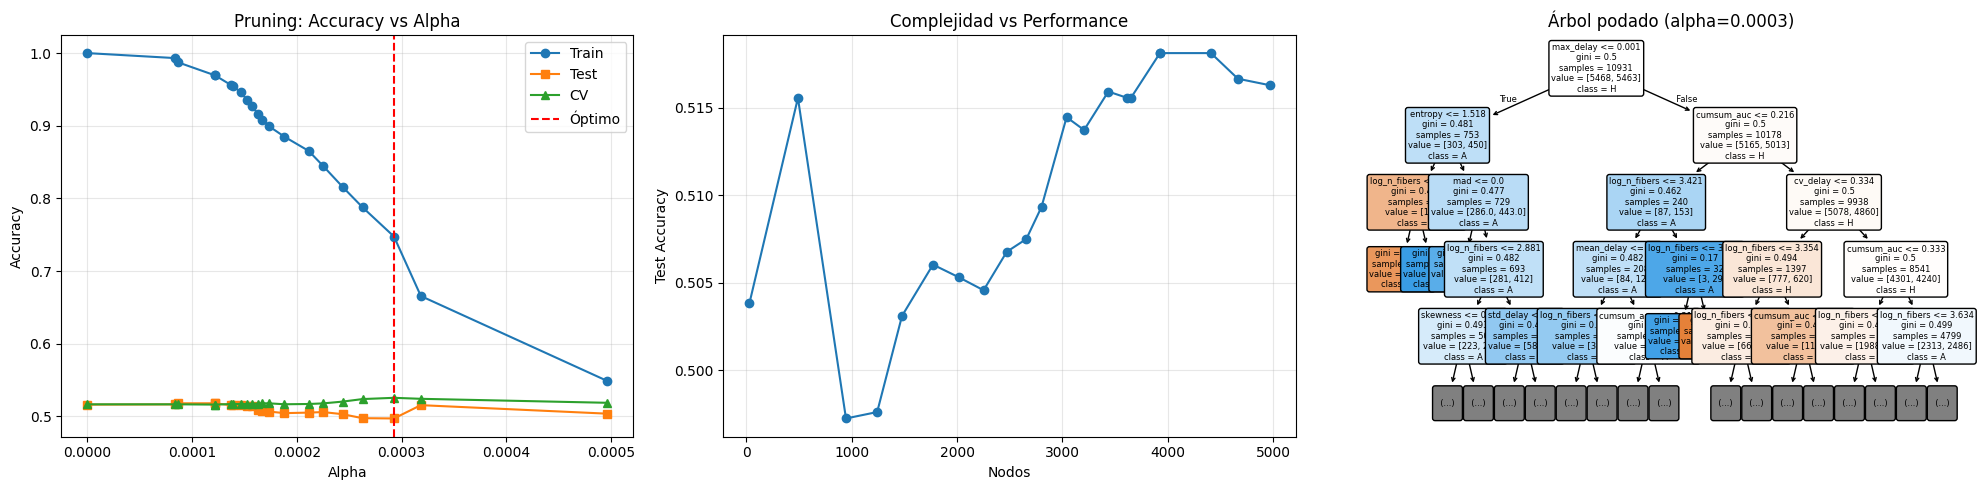

In [52]:
# === Pruning con cost complexity ===
from sklearn.tree import DecisionTreeClassifier


df_ml = df_features_robust[test_features + ['condition', 'roi_i', 'roi_j']].dropna()
df_ml['pair_id'] = df_ml['roi_i'].astype(str) + '_' + df_ml['roi_j'].astype(str)
pair_enc = LabelEncoder()
df_ml['pair_encoded'] = pair_enc.fit_transform(df_ml['pair_id'])

X = df_ml[test_features + ['pair_encoded']].values
y = (df_ml['condition'] == 'alcoholic').astype(int).values
feat_names = test_features + ['pair_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 1. Calcular path de alphas
dt_full = DecisionTreeClassifier(random_state=42)
dt_full.fit(X_train, y_train)
path = dt_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # Excluir último (árbol vacío)

# 2. Entrenar con cada alpha
train_scores = []
test_scores = []
cv_scores = []
n_nodes = []
depths = []

print(f"Probando {len(ccp_alphas)} alphas...")
for i, alpha in enumerate(ccp_alphas[::max(1, len(ccp_alphas)//20)]):  # Subsample si hay muchos
    dt = DecisionTreeClassifier(ccp_alpha=alpha, random_state=42)
    dt.fit(X_train, y_train)
    
    train_scores.append(dt.score(X_train, y_train))
    test_scores.append(dt.score(X_test, y_test))
    cv_scores.append(cross_val_score(dt, X_train, y_train, cv=3).mean())
    n_nodes.append(dt.tree_.node_count)
    depths.append(dt.tree_.max_depth)
    
    if i % 5 == 0:
        print(f"  {i+1}: alpha={alpha:.6f}, nodes={n_nodes[-1]}, test={test_scores[-1]:.3f}")

# 3. Óptimo por CV
best_idx = np.argmax(cv_scores)
best_alpha = ccp_alphas[::max(1, len(ccp_alphas)//20)][best_idx]

print(f"\nÓptimo: alpha={best_alpha:.6f}, CV={cv_scores[best_idx]:.3f}")

# 4. Entrenar modelo final
dt_pruned = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
dt_pruned.fit(X_train, y_train)

print(f"Profundidad: {dt_full.tree_.max_depth} → {dt_pruned.tree_.max_depth}")
print(f"Nodos: {dt_full.tree_.node_count} → {dt_pruned.tree_.node_count}")
print(f"Test acc: {dt_full.score(X_test, y_test):.3f} → {dt_pruned.score(X_test, y_test):.3f}")

# 5. Visualización
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(ccp_alphas[::max(1, len(ccp_alphas)//20)], train_scores, label='Train', marker='o')
axes[0].plot(ccp_alphas[::max(1, len(ccp_alphas)//20)], test_scores, label='Test', marker='s')
axes[0].plot(ccp_alphas[::max(1, len(ccp_alphas)//20)], cv_scores, label='CV', marker='^')
axes[0].axvline(best_alpha, color='r', linestyle='--', label='Óptimo')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Pruning: Accuracy vs Alpha')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(n_nodes, test_scores, marker='o')
axes[1].set_xlabel('Nodos')
axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Complejidad vs Performance')
axes[1].grid(alpha=0.3)

plot_tree(dt_pruned, ax=axes[2], feature_names=feat_names, class_names=['H', 'A'],
          filled=True, fontsize=6, max_depth=4, rounded=True)
axes[2].set_title(f'Árbol podado (alpha={best_alpha:.4f})')

plt.tight_layout()
plt.show()

Grid search: 20 combinaciones
[1/20] n=100, depth=6: acc=0.529 ← NEW BEST
[2/20] n=100, depth=8: acc=0.530 ← NEW BEST
[3/20] n=100, depth=10: acc=0.534 ← NEW BEST
[4/20] n=100, depth=12: acc=0.532
[5/20] n=100, depth=15: acc=0.534 ← NEW BEST
[6/20] n=300, depth=6: acc=0.526
[7/20] n=300, depth=8: acc=0.528
[8/20] n=300, depth=10: acc=0.534 ← NEW BEST
[9/20] n=300, depth=12: acc=0.531
[10/20] n=300, depth=15: acc=0.534 ← NEW BEST
[11/20] n=500, depth=6: acc=0.528
[12/20] n=500, depth=8: acc=0.529
[13/20] n=500, depth=10: acc=0.533
[14/20] n=500, depth=12: acc=0.532
[15/20] n=500, depth=15: acc=0.534
[16/20] n=700, depth=6: acc=0.530
[17/20] n=700, depth=8: acc=0.531
[18/20] n=700, depth=10: acc=0.534
[19/20] n=700, depth=12: acc=0.533
[20/20] n=700, depth=15: acc=0.535 ← NEW BEST

Óptimo: n=700, depth=15, score=0.535

Métricas CV:
  accuracy  : 0.535 ± 0.007
  precision : 0.538 ± 0.008
  recall    : 0.486 ± 0.009
  f1        : 0.511 ± 0.008
  roc_auc   : 0.553 ± 0.007

Confusion Matrix 

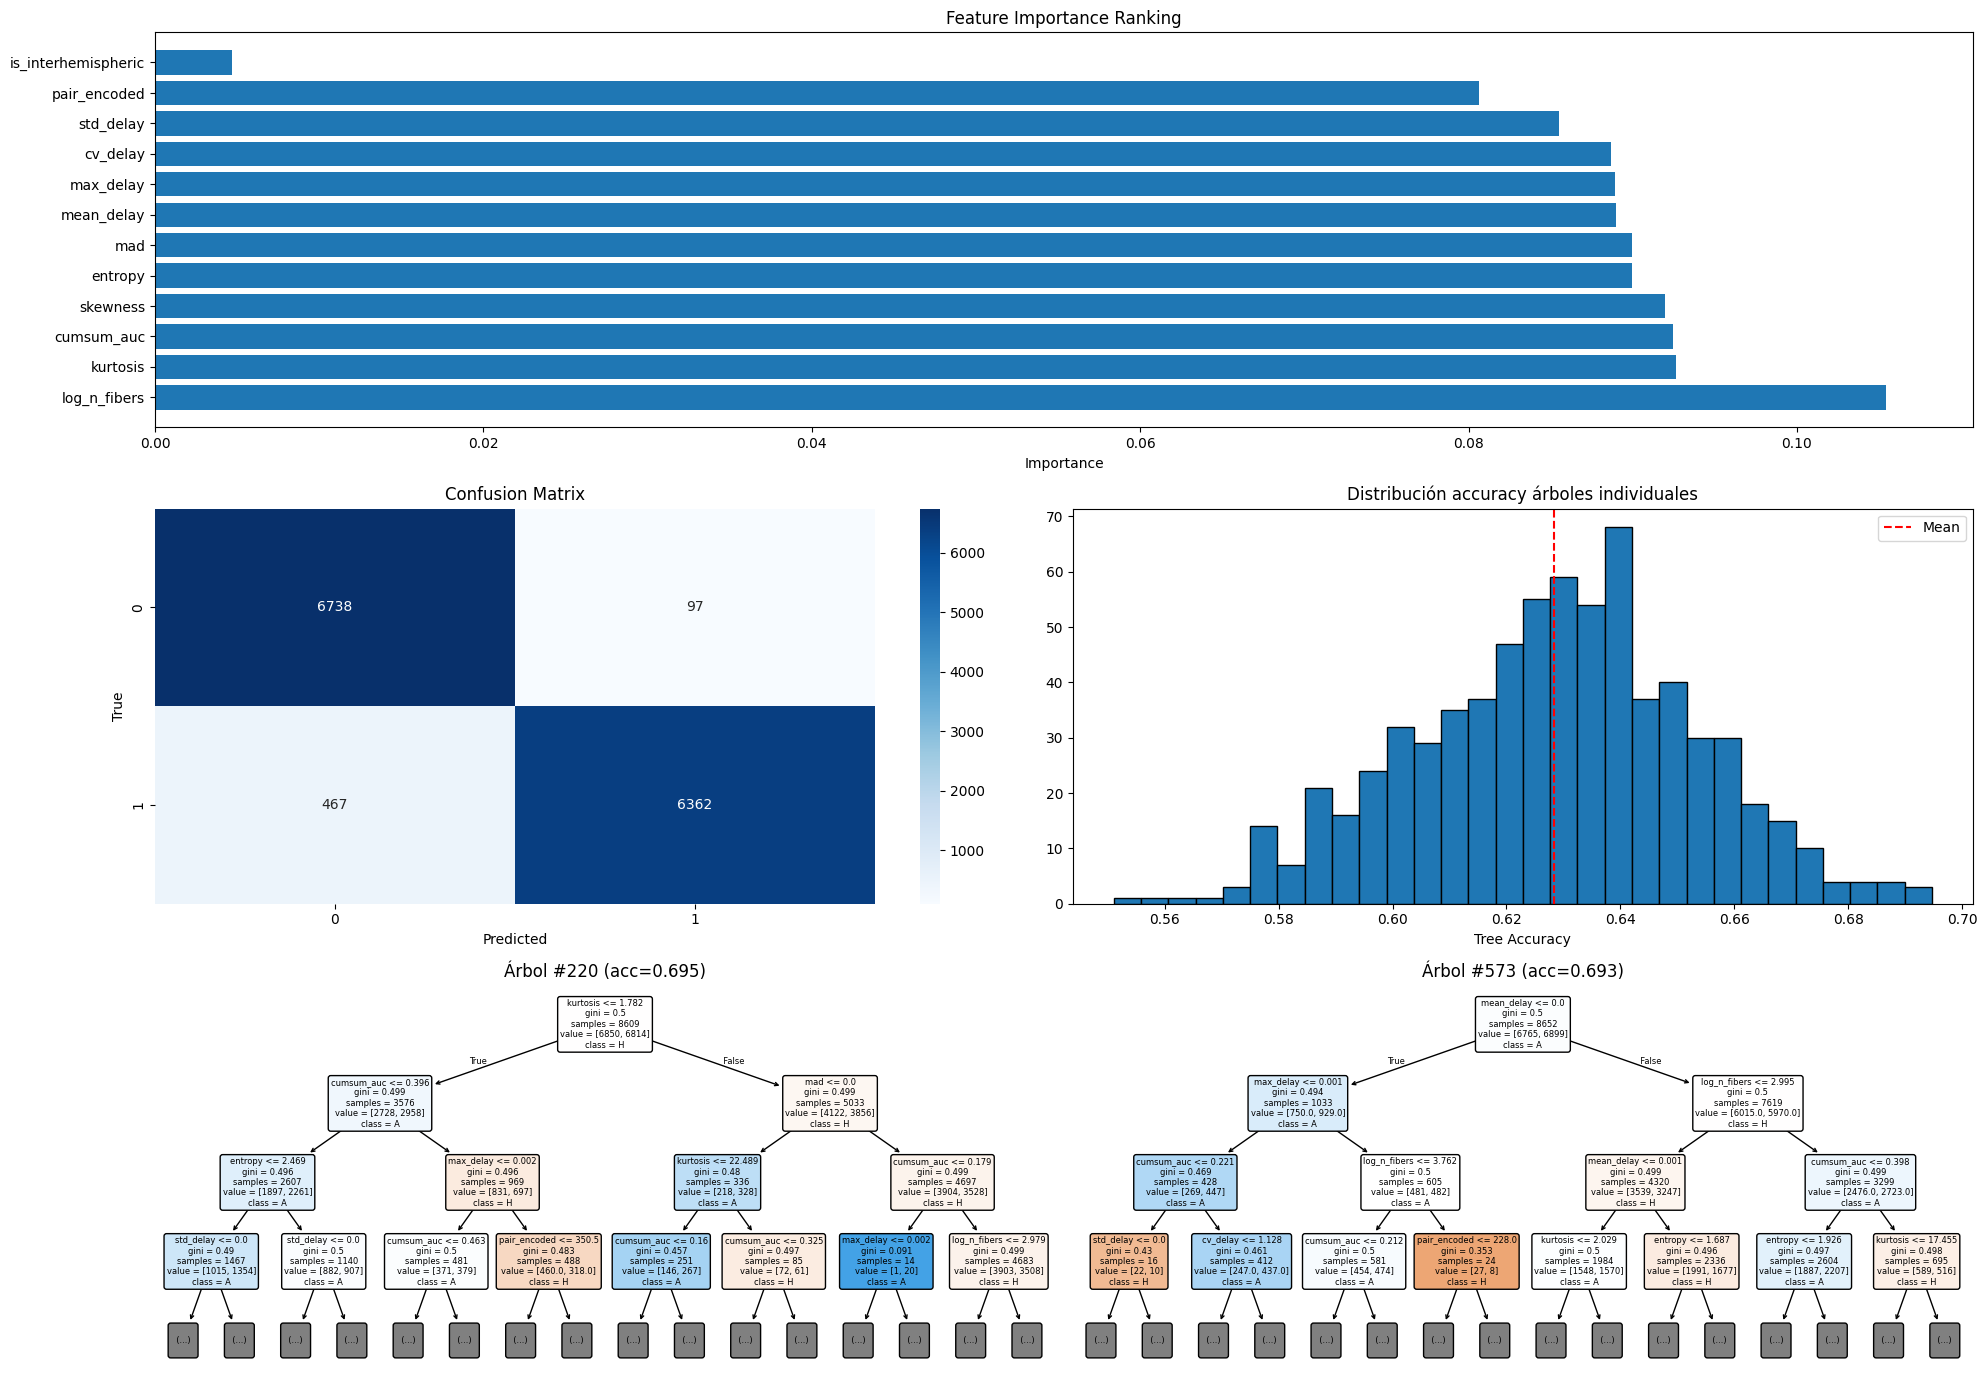

In [31]:
# === RF optimizado con análisis completo ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import plot_tree

df_ml = df_features_robust[test_features + ['condition', 'roi_i', 'roi_j']].dropna()
df_ml['pair_id'] = df_ml['roi_i'].astype(str) + '_' + df_ml['roi_j'].astype(str)
pair_enc = LabelEncoder()
df_ml['pair_encoded'] = pair_enc.fit_transform(df_ml['pair_id'])

X = df_ml[test_features + ['pair_encoded']].values
y = (df_ml['condition'] == 'alcoholic').astype(int).values
feat_names = test_features + ['pair_encoded']
cv = StratifiedKFold(5, shuffle=True, random_state=42)

# Grid search con progreso
n_estimators_range = [100, 300, 500, 700]
max_depth_range = [6, 8, 10, 12, 15]
total_iter = len(n_estimators_range) * len(max_depth_range)
current_iter = 0
best_score = 0
best_params = {}

print(f"Grid search: {total_iter} combinaciones")
for n_est in n_estimators_range:
    for depth in max_depth_range:
        current_iter += 1
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42, n_jobs=-1)
        scores = cross_validate(rf, X, y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'])
        mean_acc = scores['test_accuracy'].mean()
        
        print(f"[{current_iter}/{total_iter}] n={n_est}, depth={depth}: acc={mean_acc:.3f}", end='')
        
        if mean_acc > best_score:
            best_score = mean_acc
            best_params = {'n_estimators': n_est, 'max_depth': depth}
            print(" ← NEW BEST")
        else:
            print()

print(f"\n{'='*60}")
print(f"Óptimo: n={best_params['n_estimators']}, depth={best_params['max_depth']}, score={best_score:.3f}")
print(f"{'='*60}")

# Train y métricas completas
rf_best = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
metrics = cross_validate(rf_best, X, y, cv=cv, 
                        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

print(f"\nMétricas CV:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    vals = metrics[f'test_{metric}']
    print(f"  {metric:<10}: {vals.mean():.3f} ± {vals.std():.3f}")

rf_best.fit(X, y)
y_pred = rf_best.predict(X)

print(f"\nConfusion Matrix (train):")
print(confusion_matrix(y, y_pred))
print(f"\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Healthy', 'Alcoholic']))

# Feature importance ranking
importances = pd.DataFrame({
    'feature': feat_names,
    'importance': rf_best.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\nRanking features:")
print(importances.to_string(index=False))

# Analizar árboles individuales
tree_metrics = []
for idx, tree in enumerate(rf_best.estimators_):
    tree_pred = tree.predict(X)
    acc = (tree_pred == y).mean()
    depth = tree.tree_.max_depth
    tree_metrics.append({'idx': idx, 'accuracy': acc, 'depth': depth})

df_trees = pd.DataFrame(tree_metrics).sort_values('accuracy', ascending=False)
print(f"\nTop 5 árboles:")
print(df_trees.head(5).to_string(index=False))

# Visualización
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 2)

# Feature importance
ax1 = fig.add_subplot(gs[0, :])
ax1.barh(importances['feature'], importances['importance'])
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance Ranking')

# Confusion matrix
ax2 = fig.add_subplot(gs[1, 0])
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')

# Distribución accuracy árboles
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(df_trees['accuracy'], bins=30, edgecolor='black')
ax3.axvline(df_trees['accuracy'].mean(), color='r', linestyle='--', label='Mean')
ax3.set_xlabel('Tree Accuracy')
ax3.set_title('Distribución accuracy árboles individuales')
ax3.legend()

# Mejores 2 árboles
for i, gs_idx in enumerate([gs[2, 0], gs[2, 1]]):
    best_tree_idx = int(df_trees.iloc[i]['idx'])
    ax = fig.add_subplot(gs_idx)
    plot_tree(rf_best.estimators_[best_tree_idx], ax=ax,
             feature_names=feat_names, class_names=['H', 'A'],
             filled=True, fontsize=6, max_depth=3, rounded=True)
    ax.set_title(f'Árbol #{best_tree_idx} (acc={df_trees.iloc[i]["accuracy"]:.3f})')

plt.tight_layout()
plt.show()

**Insights Random Forest:**

**Performance:**
- CV: 53.5% accuracy, 55.3% AUC → **apenas mejor que azar**
- Plateau en 0.534 con múltiples configs → saturación
- Train 96% vs CV 53.5% → **overfitting severo** incluso con ensemble

**Optimización inútil:**
- n=100 vs n=700: +0.1% ganancia → más árboles no ayudan
- Depth=6 vs 15: +0.5% → complejidad tampoco ayuda

**Feature importance:**
- log_n_fibers (10.5%) top → densidad fibras más discriminativa
- Temporales uniformes (8-9%) → ninguna domina
- pair_encoded baja (8% vs 12% DT) → ensemble diluye identidad
- is_interhemispheric irrelevante (0.5%)

**Árboles individuales:**
- Best: 69.5% acc → ninguno es bueno
- Ensemble promedia ruido


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Grid search XGBoost: 36 combinaciones
[1/36] n=100, depth=4, lr=0.01: acc=0.517 ← NEW BEST
[2/36] n=100, depth=4, lr=0.05: acc=0.527 ← NEW BEST
[3/36] n=100, depth=4, lr=0.1: acc=0.529 ← NEW BEST
[4/36] n=100, depth=6, lr=0.01: acc=0.525
[5/36] n=100, depth=6, lr=0.05: acc=0.530 ← NEW BEST
[6/36] n=100, depth=6, lr=0.1: acc=0.532 ← NEW BEST
[7/36] n=100, depth=8, lr=0.01: acc=0.526
[8/36] n=100, depth=8, lr=0.05: acc=0.527
[9/36] n=100, depth=8, lr=0.1: acc=0.533 ← NEW BEST
[10/36] n=100, depth=10, lr=0.01: acc=0.530
[11/36] n=100, depth=10, lr=0.05: acc=0.527
[12/36] n=100, depth=10, lr=0.1: acc=0.527
[13/36] n=300, depth=4, lr=0.01: acc=0.527
[14/36] n=300, depth=4, lr=0.05: acc=0.526
[15/36] n=300, depth=4, lr=0.1: acc=0.528
[16/36] n=300, depth=6, lr=0.01: acc=0.527
[17/36] n=300, depth=6, lr=0.05: acc=0.526
[18/36] n=300, depth=6, lr=0.1: acc=0.529
[19/36] n=300, depth=8, lr=0.01: acc=0.526
[20

/home/tonicoll/.conda/envs/neuro_env/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.568211 to fit


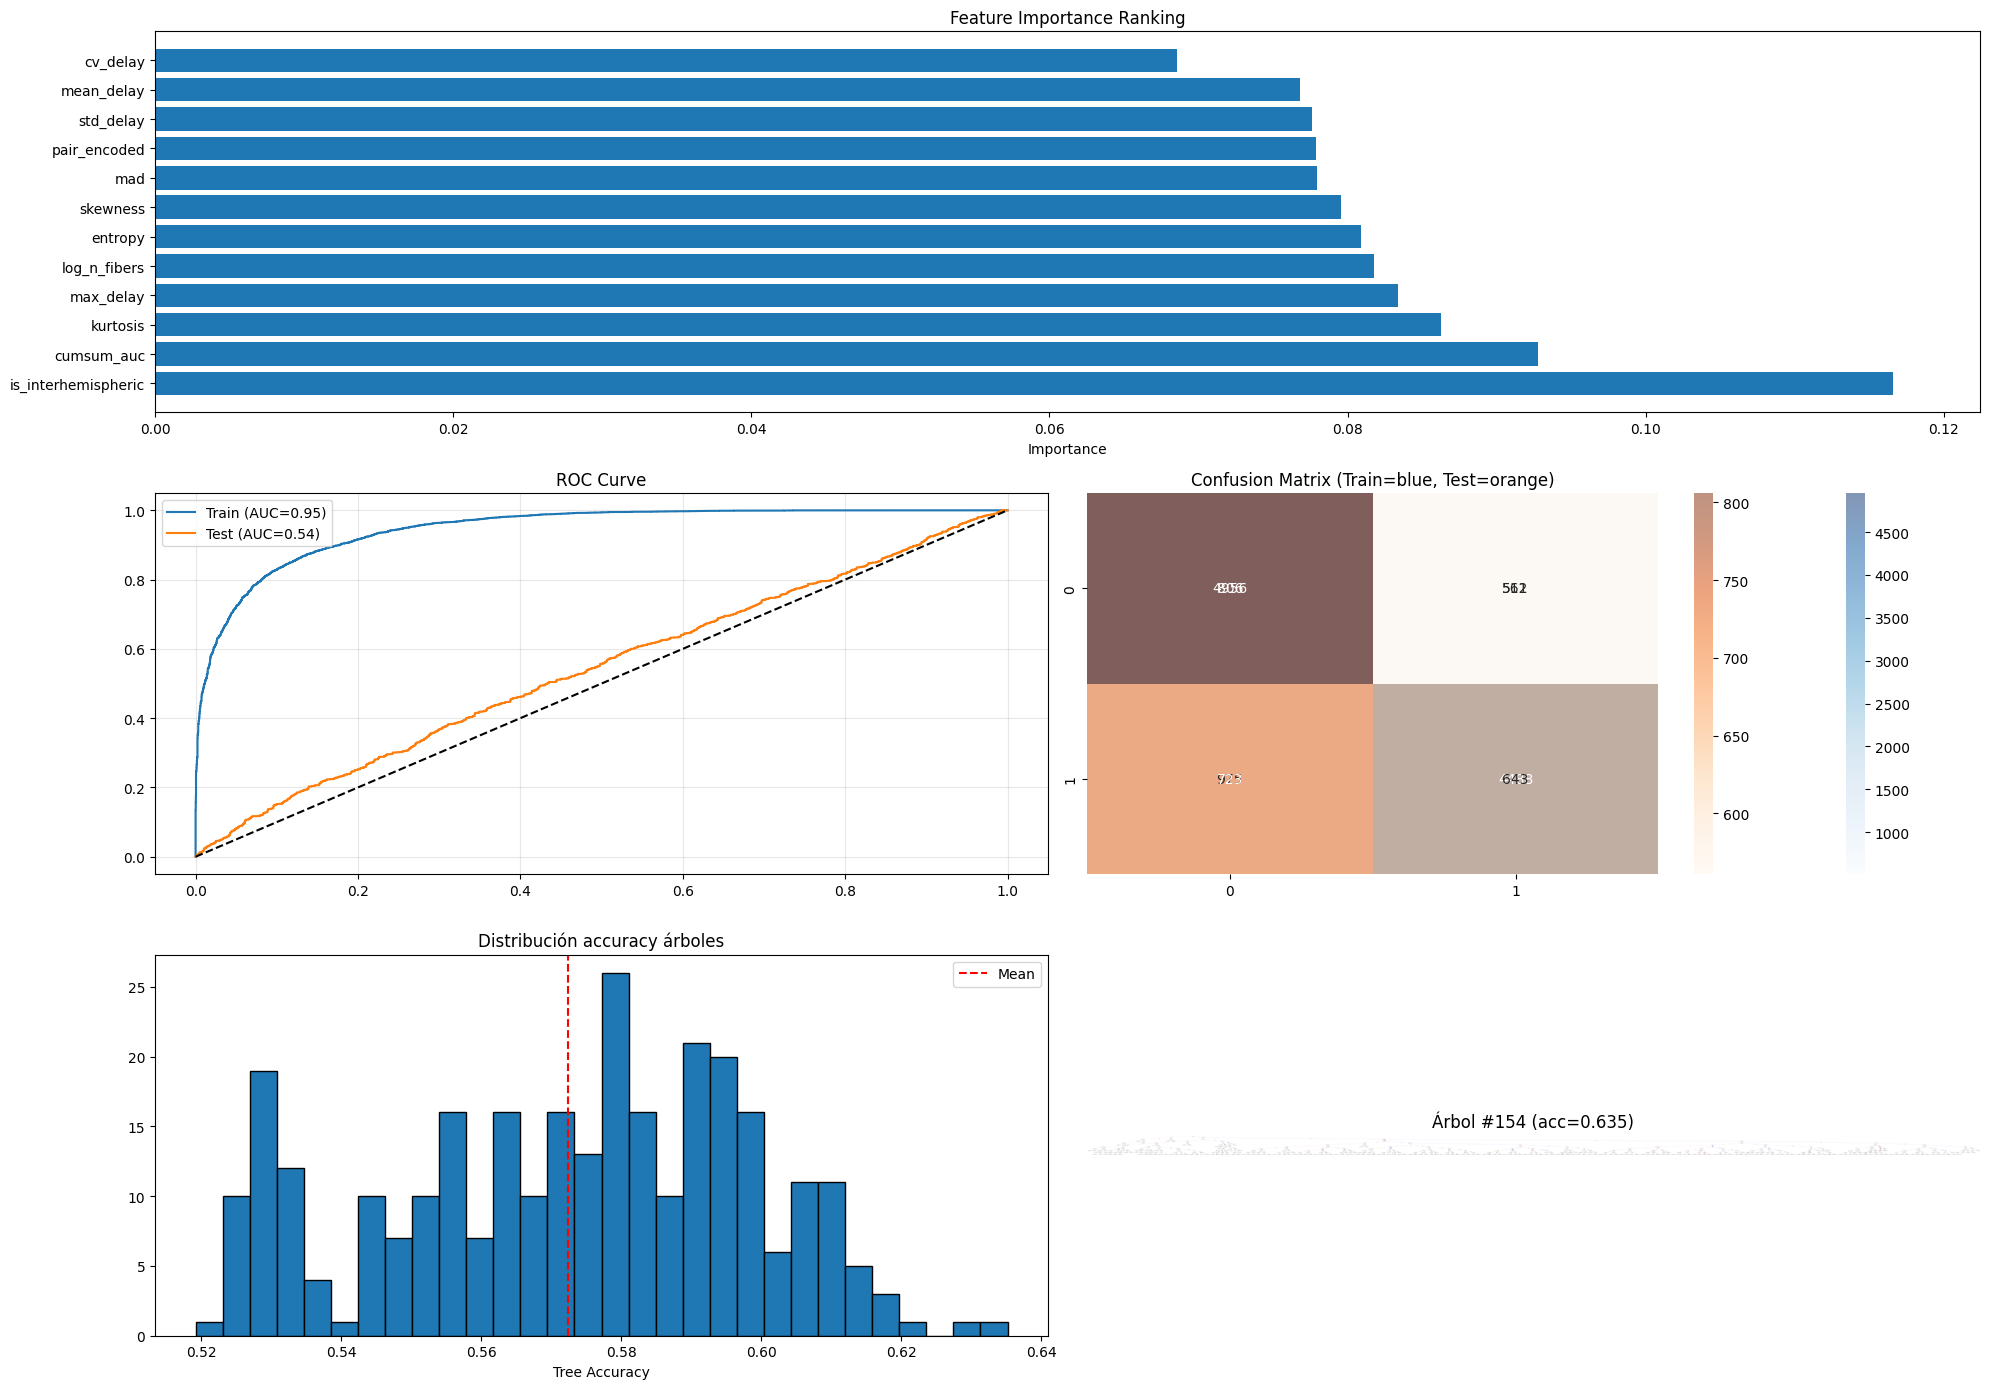

In [54]:
%load_ext autoreload
%autoreload 2

# === XGBoost optimizado con análisis completo ===
from xgboost import XGBClassifier, plot_tree as xgb_plot_tree
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

df_ml = df_features_robust[test_features + ['condition', 'roi_i', 'roi_j']].dropna()
df_ml['pair_id'] = df_ml['roi_i'].astype(str) + '_' + df_ml['roi_j'].astype(str)
pair_enc = LabelEncoder()
df_ml['pair_encoded'] = pair_enc.fit_transform(df_ml['pair_id'])

X = df_ml[test_features + ['pair_encoded']].values
y = (df_ml['condition'] == 'alcoholic').astype(int).values
feat_names = test_features + ['pair_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Grid search
n_estimators_range = [100, 300, 500]
max_depth_range = [4, 6, 8, 10]
learning_rate_range = [0.01, 0.05, 0.1]
cv = StratifiedKFold(5, shuffle=True, random_state=42)

total_iter = len(n_estimators_range) * len(max_depth_range) * len(learning_rate_range)
current_iter = 0
best_score = 0
best_params = {}

print(f"Grid search XGBoost: {total_iter} combinaciones")
for n_est in n_estimators_range:
    for depth in max_depth_range:
        for lr in learning_rate_range:
            current_iter += 1
            xgb = XGBClassifier(n_estimators=n_est, max_depth=depth, learning_rate=lr,
                               random_state=42, n_jobs=-1, eval_metric='logloss')
            scores = cross_validate(xgb, X_train, y_train, cv=cv, scoring=['accuracy'])
            mean_acc = scores['test_accuracy'].mean()
            
            print(f"[{current_iter}/{total_iter}] n={n_est}, depth={depth}, lr={lr}: acc={mean_acc:.3f}", end='')
            
            if mean_acc > best_score:
                best_score = mean_acc
                best_params = {'n_estimators': n_est, 'max_depth': depth, 'learning_rate': lr}
                print(" ← NEW BEST")
            else:
                print()

print(f"\n{'='*60}")
print(f"Óptimo: n={best_params['n_estimators']}, depth={best_params['max_depth']}, lr={best_params['learning_rate']}, score={best_score:.3f}")
print(f"{'='*60}")

# Train con mejores parámetros
xgb_best = XGBClassifier(**best_params, random_state=42, n_jobs=-1, eval_metric='logloss')
metrics = cross_validate(xgb_best, X_train, y_train, cv=cv,
                        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

print(f"\nMétricas CV:")
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    vals = metrics[f'test_{metric}']
    print(f"  {metric:<10}: {vals.mean():.3f} ± {vals.std():.3f}")

xgb_best.fit(X_train, y_train)
y_train_pred = xgb_best.predict(X_train)
y_train_proba = xgb_best.predict_proba(X_train)[:, 1]
y_test_pred = xgb_best.predict(X_test)
y_test_proba = xgb_best.predict_proba(X_test)[:, 1]

print(f"\nTrain accuracy: {xgb_best.score(X_train, y_train):.3f}")
print(f"Test accuracy:  {xgb_best.score(X_test, y_test):.3f}")

# Feature importance
importances = pd.DataFrame({
    'feature': feat_names,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\nRanking features:")
print(importances.to_string(index=False))

# Analizar árboles
tree_metrics = []
for idx in range(xgb_best.n_estimators):
    tree_pred = xgb_best.predict(X_train, iteration_range=(idx, idx+1))
    acc = (tree_pred == y_train).mean()
    tree_metrics.append({'idx': idx, 'accuracy': acc})

df_trees = pd.DataFrame(tree_metrics).sort_values('accuracy', ascending=False)

# Visualización
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 2)

# Feature importance
ax1 = fig.add_subplot(gs[0, :])
ax1.barh(importances['feature'], importances['importance'])
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance Ranking')

# ROC
ax2 = fig.add_subplot(gs[1, 0])
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
ax2.plot(fpr_train, tpr_train, label=f'Train (AUC={auc(fpr_train, tpr_train):.2f})')
ax2.plot(fpr_test, tpr_test, label=f'Test (AUC={auc(fpr_test, tpr_test):.2f})')
ax2.plot([0,1], [0,1], 'k--')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(alpha=0.3)

# Confusion matrices
ax3 = fig.add_subplot(gs[1, 1])
cms = [confusion_matrix(y_train, y_train_pred), confusion_matrix(y_test, y_test_pred)]
sns.heatmap(cms[0], annot=True, fmt='d', cmap='Blues', ax=ax3, alpha=0.5)
sns.heatmap(cms[1], annot=True, fmt='d', cmap='Oranges', ax=ax3, alpha=0.5)
ax3.set_title('Confusion Matrix (Train=blue, Test=orange)')

# Distribución accuracy árboles
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(df_trees['accuracy'], bins=30, edgecolor='black')
ax4.axvline(df_trees['accuracy'].mean(), color='r', linestyle='--', label='Mean')
ax4.set_xlabel('Tree Accuracy')
ax4.set_title('Distribución accuracy árboles')
ax4.legend()

# Mejor árbol
ax5 = fig.add_subplot(gs[2, 1])
best_tree_idx = int(df_trees.iloc[0]['idx'])
xgb_plot_tree(xgb_best, num_trees=best_tree_idx, ax=ax5)
ax5.set_title(f'Árbol #{best_tree_idx} (acc={df_trees.iloc[0]["accuracy"]:.3f})')

plt.tight_layout()
plt.show()

**XGBoost vs Random Forest:**

| Métrica | XGBoost | RF |
|---------|---------|-----|
| CV Accuracy | 53.4% | 53.5% |
| AUC | 54.5% | 55.3% |
| Train/Test gap | 86%/53% | 96%/53% |
| Top feature | is_interhemispheric (12%) | log_n_fibers (11%) |

**Insights:**
- **Rendimiento idéntico** → saturación con features agregadas
- XGB penaliza más overfitting (train 86% vs RF 96%), pero test igual
- is_interhemispheric sube en XGB → captura algo de estructura anatómica
- Plateau 53-54% → techo con estas features

**Conclusión definitiva:** 3 modelos (DT, RF, XGB) convergen a ~53% accuracy. Features estadísticas agotadas.